# Preamble

This notebook implements the methods for loading and analysing the data that was used for training the quality classifier.
It also shows how different classifiers were trained, and evaluates their respective outputs.

This is a protoypical implementation that requires adaptations to run on other datasets.

Some of the code is licensed under the GPL, and was copied from [nautlius-ocr](https://github.com/natliblux/nautilusocr).

# Initialize

In [333]:
%pip install spylls
%pip install pagexml-tools
%pip install tqdm
%pip install pandas matplotlib seaborn scikit-learn graphviz openpyxl

%conda install --channel conda-forge pygraphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [334]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn


In [335]:
from pathlib import Path

REPOSITORY_PATH = Path().parent.absolute()

SOURCE_DIR = REPOSITORY_PATH / "text_quality"

DATA_DIR = SOURCE_DIR / "data"

if not DATA_DIR.is_dir():
    raise NotADirectoryError(DATA_DIR.absolute)


# Read Ground Truth

In [336]:
GROUND_TRUTH_URL="https://zenodo.org/record/6414086/files/VOC%20Ground%20truths%20of%20the%20trainingset%20in%20PAGE%20xml.7z"

!wget -c $GROUND_TRUTH_URL

--2023-06-08 11:44:10--  https://zenodo.org/record/6414086/files/VOC%20Ground%20truths%20of%20the%20trainingset%20in%20PAGE%20xml.7z
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [337]:
# TODO: Download and decompress "VOC Ground truths of the trainingset in PAGE xml.7z" from https://zenodo.org/record/6414086


GROUND_TRUTH_PATH = REPOSITORY_PATH / "VOC Ground truths of the trainingset in PAGE xml"
assert (
    GROUND_TRUTH_PATH.is_dir()
), f"Directory containing ground truth not found at {GROUND_TRUTH_PATH.absolute()}"


GROUND_TRUTH_FILES = list(GROUND_TRUTH_PATH.glob("*.xml"))
expected_files = 4735
assert (
    len(GROUND_TRUTH_FILES) == expected_files
), f"Found {len(GROUND_TRUTH_FILES)} files, but expected {expected_files}."


In [338]:
from pagexml.parser import parse_pagexml_file
from tqdm import tqdm

pagexml_files = [parse_pagexml_file(file) for file in tqdm(GROUND_TRUTH_FILES)]


100%|██████████| 4735/4735 [04:27<00:00, 17.69it/s]  


# General Functions

In [339]:
import logging
from typing import List


HYPHENS = {"-", "⸗", "="}


def get_tokens(text) -> List[str]:
    """Copied from features_epr.py"""
    if pd.isna(text):
        logging.warning("No text given.")
        return []
    tokens = list()

    new_token = ""
    for c in text:
        if c == " " and len(new_token) > 0:
            tokens.append(new_token)
            new_token = ""
        elif c == "\n" and len(new_token) > 0:
            if new_token[-1] in HYPHENS:
                new_token = new_token[:-1]
            else:
                tokens.append(new_token)
                new_token = ""
        else:
            new_token += c
    if len(new_token) > 0:
        tokens.append(new_token)

    for i, token in enumerate(tokens):
        if not token[-1].isalpha():
            tokens[i] = token[:-1]
        if not token[0].isalpha():
            tokens[i] = token[1:]

    return tokens


# Dictionary Lookup

## Hunspell

In [340]:
LANGUAGE = "nl"

HUNSPELL_DICT_PATH = DATA_DIR / "dicts" / "hunspell"
assert HUNSPELL_DICT_PATH.is_dir()

SUFFIXES = [".aff", ".dic"]

assert HUNSPELL_DICT_PATH.is_dir()

assert all(
    (HUNSPELL_DICT_PATH / Path(LANGUAGE).with_suffix(suffix)).is_file()
    for suffix in [".aff", ".dic"]
)


In [341]:
from spylls.hunspell import Dictionary

hunspell = Dictionary.from_files(str(HUNSPELL_DICT_PATH / Path(LANGUAGE)))


In [342]:
from typing import List


def get_dict_score(tokens: List[str]):
    if any(len(token) > 0 for token in tokens):
        matched_count = 0
        total_count = 0

        for token in tokens:
            total_count += len(token)

            # TODO: lowercase token?
            matched_count += hunspell.lookup(token) * len(token)

        return matched_count / total_count
    else:
        return 0.0


In [343]:
tokens = ["Dit", "is", "een", "text"]

get_dict_score(tokens)


0.6666666666666666

## Ground Truth Dictionary

In [344]:
from pagexml.parser import parse_pagexml_file
from tqdm import tqdm
import random

words = set()

for pagexml in tqdm(pagexml_files):
    for line in pagexml.get_lines():
        if line.text is not None:
            words.update(get_tokens(line.text))

random.sample(words, 10)


100%|██████████| 4735/4735 [00:02<00:00, 2155.97it/s]
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_70879/3298027077.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(words, 10)


['Loescheng',
 'Kooije',
 'locete',
 'inretour',
 'Feb„r',
 'meenighte',
 'praesentatie',
 'mogste',
 'Eerstgem',
 'gebleeckt']

In [345]:
VOC_DICT_OUTPUT_FILE = HUNSPELL_DICT_PATH / "nl_voc.txt"

# if VOC_DICT_OUTPUT_FILE.exists():
#     raise FileExistsError(VOC_DICT_OUTPUT_FILE)

# with open(VOC_DICT_OUTPUT_FILE, "wt") as f:
#     f.write("\n".join(sorted(words)))


In [346]:
def get_dict_score_gt(tokens):
    if any(len(token) > 0 for token in tokens):
        matched_count = 0
        total_count = 0

        for token in tokens:
            total_count += len(token)

            # TODO: lowercase token?
            matched_count += (token in words) * len(token)

        return matched_count / total_count
    else:
        return 0.0


# Train Tri-Gram Model

## Functions

In [347]:
from typing import List


NGRAM_LENGTH = 3


def get_ngrams(tokens) -> List[str]:
    """Copied, adapted from features_epr.py"""

    n_grams = list()
    for token in tokens:
        token_list = list(token)
        for i in range(0, len(token_list)):
            if not token[i].isalpha():
                token_list[i] = " "
        modified_token = "".join(token_list)
        splits = modified_token.split(" ")
        for split in splits:
            if split != "":
                for i in range(0, len(split) - NGRAM_LENGTH + 1):
                    n_grams.append(split[i : i + NGRAM_LENGTH].lower())
    return n_grams


In [348]:
def get_ngram_score(ngrams, lang_ngrams) -> float:
    """Copied from features_epr.py"""
    # TODO: this is very slow
    # TODO: check if this corresponds to equation 10 in the paper?

    if len(ngrams) == 0:
        return 0

    score = 0
    for ngram in ngrams:
        for i in range(0, len(lang_ngrams)):
            if ngram == lang_ngrams[i]:
                score += 1 - (1 / len(lang_ngrams) * i)
                break

    score = score / len(ngrams)
    return score


## Generate Model

In [349]:
from collections import Counter

from tqdm import tqdm


lang_trigrams = list()

for file in tqdm(pagexml_files, unit="file"):
    for line in pagexml.get_lines():
        tokens = get_tokens(line.text) if line.text else []
        lang_trigrams.extend(get_ngrams(tokens))

print(f"Total n-grams: {len(lang_trigrams)}")
print(f"Distinct n-grams: {len(set(lang_trigrams))}")
print(f"Most common n-grams: ")

Counter(lang_trigrams).most_common(10)


100%|██████████| 4735/4735 [00:02<00:00, 1868.43file/s]


Total n-grams: 2864675
Distinct n-grams: 312
Most common n-grams: 


[('ver', 56820),
 ('den', 52085),
 ('oor', 42615),
 ('ers', 37880),
 ('gen', 33145),
 ('nde', 33145),
 ('rde', 33145),
 ('der', 33145),
 ('voo', 28410),
 ('aar', 28410)]

In [350]:
# Store trigram list

OUTPUT_FILE = REPOSITORY_PATH / "trigrams.txt"
if OUTPUT_FILE.exists():
    logging.warning(f"File aready exists: '{str(OUTPUT_FILE.absolute())}")
    # raise FileExistsError(OUTPUT_FILE)
else:
    with open(OUTPUT_FILE, "wt") as f:
        f.write("\n".join(lang_trigrams))


In [351]:
import os

os.linesep.join([line.text for line in pagexml.get_lines()])


"386\nden 15: Meij 1782.\nDe koning vervolgens te kennen hebbende ge\n„geven hoe node het den Limbotters voorgekomen\nis wegens de van hen gevergde verhuizing\nnaar hun oude woonplaats Limbotto veront„\n„rust te worden: wierd goedgevonden en verstaan\nte repliceeren dat die verhuizing als nuttig\nvoor de Comp:e en naar het oordeel deezer Regee„\n„ring ook nuttig voor de Limbotters zelven\nalleen voorgeslagen en nimmer volstrekt\nop hen begeerd is; dat de Limbotters geen\nzin hebbende in de opbrake van Quandang\nals dan ook behoorden te zorgen dat de ge„\n„bouwen waar onder Comp:s dienaren moeten\nhuisvesten en hare effecten bewaard worden\nweder uit den vervallen staat waarinne men\nverneemd dat geraakt zijn, getrokken wierden\nen altoos 's Comp:s belangens in dien ooird moes„\nten in het oog houden welk laatste niet wel\nanders geschieden kan dan door eene vermeer„\n„derde goud Leverantie.\n/:onderstond:) Aldus gedaan en Gereselveerd tot\nTernaten in’t Kasteel Orange dato voorschreven

In [352]:
text = "Dit is eenasd teksthdgfhfgh"

tokens = get_tokens(text)
trigrams = get_ngrams(tokens)

get_ngram_score(trigrams, lang_trigrams)


0.1874795570178118

In [353]:
# TODO:
scores = Counter()
file_trigrams = list()

for line in pagexml.get_lines():
    text = line.text
    tokens = get_tokens(text)
    line_trigrams = get_ngrams(tokens)
    scores[text] = get_ngram_score(line_trigrams, lang_trigrams)

    file_trigrams.extend(line_trigrams)

scores.most_common()


[('den 15: Meij 1782.', 0.9999996509202616),
 ('De koning vervolgens te kennen hebbende ge', 0.9999952874235297),
 ('hebbende', 0.9999924947856215),
 ('„geven hoe node het den Limbotters voorgekomen', 0.9999875308717395),
 ('is wegens de van hen gevergde verhuizing', 0.9999846230375171),
 ('naar hun oude woonplaats Limbotto veront„', 0.9999767634313173),
 ('„rust te worden: wierd goedgevonden en verstaan', 0.9999710822344593),
 ('op hen begeerd is; dat de Limbotters geen', 0.9999699586083833),
 ('„ring ook nuttig voor de Limbotters zelven', 0.9999696300627472),
 ('te repliceeren dat die verhuizing als nuttig', 0.9999643065967342),
 ('voor de Comp:e en naar het oordeel deezer Regee„', 0.9999619135632636),
 ('als dan ook behoorden te zorgen dat de ge„', 0.9999535258508093),
 ('Limbotters van Quandang is wel', 0.9999528306003298),
 ('voorgeslagen maar geen zin', 0.9999492205340339),
 ('zin hebbende in de opbrake van Quandang', 0.9999475829213657),
 ('alleen voorgeslagen en nimmer volstrek

In [354]:
get_ngram_score(file_trigrams, lang_trigrams)


0.9999367438664196

# Garbage Token Detection

## Functions

In [355]:
EPR_RULE1 = 21
EPR_RULE2 = 3
EPR_RULE3 = 4
EPR_RULE4 = 6
EPR_RULE5 = 8
EPR_RULE9 = 2

VOWELS = "aäàáâǎeéèêëěiîïíìıoöôòóǒuüûùúǔ"


def get_garbage_score(tokens):
    """Copied from features_epr.py"""

    issues = 0

    if len(tokens) == 0:
        return 0

    for token in tokens:

        # rule1
        if len(token) >= EPR_RULE1:
            issues += 1
            continue

        vowel_count = 0
        consonant_count = 0
        lower_case_count = 0
        upper_case_count = 0
        special_char_count = 0
        non_outer_special_chars = set()
        alpha = True
        last_char = None
        repitition_streak = 0
        vowel_streak = 0
        consonant_streak = 0
        go_to_next_token = False
        for i in range(0, len(token)):
            go_to_next_token = False
            char = token[i]

            # collect token info
            if char.isalpha():
                if char.lower() in VOWELS:
                    vowel_count += 1
                    vowel_streak += 1
                    consonant_streak = 0
                else:
                    consonant_count += 1
                    consonant_streak += 1
                    vowel_streak = 0
                if char.isupper():
                    upper_case_count += 1
                else:
                    lower_case_count += 1
            elif char.isalnum():
                alpha = False
                vowel_streak = 0
                consonant_streak = 0
            else:
                special_char_count += 1
                alpha = False
                vowel_streak = 0
                consonant_streak = 0
                if i != 0 and i != len(token) - 1:
                    non_outer_special_chars.add(char)

            # rule 3
            if vowel_streak >= EPR_RULE3:
                issues += 1
                go_to_next_token = True
                break

            # rule 4
            if consonant_streak >= EPR_RULE4:
                issues += 1
                go_to_next_token = True
                break

            if last_char != None and char == last_char:
                repitition_streak += 1

                # rule 2
                if repitition_streak >= EPR_RULE2:
                    issues += 1
                    go_to_next_token = True
                    break
            else:
                repitition_streak = 0
            last_char = char

        if go_to_next_token:
            continue

        if alpha and vowel_count > 0 and consonant_count > 0:
            # rule 5
            if vowel_count * EPR_RULE5 < consonant_count:
                issues += 1
                continue
            # rule 5
            if consonant_count * EPR_RULE5 < vowel_count:
                issues += 1
                continue

        # rule 6
        if lower_case_count > 0 and upper_case_count > lower_case_count:
            issues += 1
            continue

        # rule 7
        if (
            upper_case_count > 0
            and token[0].islower()
            and token[len(token) - 1].islower()
        ):
            issues += 1
            continue

        # rule 8
        regular_chars = len(token) - special_char_count
        if special_char_count >= regular_chars and regular_chars > 0:
            issues += 1
            continue

        # rule 9
        if len(non_outer_special_chars) >= EPR_RULE9:
            issues += 1
            continue

    return issues / len(tokens)


In [356]:
get_garbage_score(get_tokens(text))


0.0

# Publication Year Consideration

In [357]:
METADATA_FILE = DATA_DIR / "1.04.02_dates.csv"
assert METADATA_FILE.exists(), f"File does not exist: '{str(METADATA_FILE.absolute)}'."


In [358]:
years = pd.read_csv(
    METADATA_FILE,
    sep="\t",
    # dtype={"year_begin": "int64", "year_end": "int64"}, ,
)
years


,inventory_number,title,handle,date_text,date_iso,year_begin,year_end
0,1,Octrooi verleend door de Staten-Generaal betre...,http://hdl.handle.net/10648/0608f568-2f71-4f1e...,1602,1602,1602.0,1602.0
1,2,Octrooiverlenging verleend door de Staten-Gene...,http://hdl.handle.net/10648/c0a0d010-f235-4c7f...,1622,1622,1622.0,1622.0
2,3,Ordonnantie van de Staten-Generaal betreffende...,http://hdl.handle.net/10648/22dab3f2-0370-4fa6...,1623,1623,1623.0,1623.0
3,4,Octrooiverlenging verleend door de Staten-Gene...,http://hdl.handle.net/10648/71bd8115-d39d-40c3...,1647,1647,1647.0,1647.0
4,5,Octrooiverlenging verleend door de Staten-Gene...,http://hdl.handle.net/10648/436ba461-26c0-47fd...,1665,1665,1665.0,1665.0
...,...,...,...,...,...,...,...
16437,14928,Inventaris van de archieven van de kamer Delft...,http://hdl.handle.net/10648/167e54e3-9c61-4f61...,[c. 1802],1797/1807,1797.0,1807.0
16438,14929,Inventaris van de koloniale archieven die bij ...,http://hdl.handle.net/10648/86b99052-4bc6-4955...,[c. 1809],1804/1814,1804.0,1814.0
16439,14930,Inventaris van de koloniale archieven van Oost...,http://hdl.handle.net/10648/9818e85c-eb82-4651...,[c. 1809],1804/1814,1804.0,1814.0
16440,14931,Inventaris van de Oostindische archieven die i...,http://hdl.handle.net/10648/976456b5-ffca-49d9...,1829,1829,1829.0,1829.0


In [359]:
years.dtypes


inventory_number     object
title                object
handle               object
date_text            object
date_iso             object
year_begin          float64
year_end            float64
dtype: object

# Scoring

In [360]:
JUDGEMENTS_FILE = DATA_DIR / "limited2 review overview 20220713.csv"
if not JUDGEMENTS_FILE.is_file():
    raise FileNotFoundError(JUDGEMENTS_FILE.absolute())


In [361]:
PAGES_DIR = DATA_DIR / "page"
if not PAGES_DIR.is_dir():
    raise NotADirectoryError(PAGES_DIR.absolute())


## Read Judgements

In [362]:
import pandas as pd

judgements = pd.read_csv(JUDGEMENTS_FILE, index_col=0).rename(
    {"Unnamed: 11": "url"}, axis="columns"
)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN


In [363]:
judgements[["Ranking Kay", "Ranking Maartje"]].corr()


,Ranking Kay,Ranking Maartje
Ranking Kay,1.000000,0.626003
Ranking Maartje,0.626003,1.000000


### Read Error Types

In [364]:
ERROR_TYPOLOGY_FILE = DATA_DIR / "Error Typology limited2 MH.xlsx"
assert ERROR_TYPOLOGY_FILE.is_file()


In [365]:
error_types = pd.read_excel(
    ERROR_TYPOLOGY_FILE, usecols=["Filename", "Line No", "Error Code"]
).dropna(subset="Error Code")
error_types


,Filename,Line No,Error Code
0,NL-HaNA_1.04.02_1108_1273,06-01,4.7
1,NL-HaNA_1.04.02_1108_1273,10-38,4.7
2,NL-HaNA_1.04.02_1108_1273,-,4.3
3,NL-HaNA_1.04.02_1636_0070,3-25,3.2
4,NL-HaNA_1.04.02_1636_0070,4-2,4.7
...,...,...,...
143,NL-HaNA_1.04.02_3764_0415,-,3.2
144,NL-HaNA_1.04.02_3970_0021,1-1,4.8
145,NL-HaNA_1.04.02_3970_0021,4-1,2.4.1
146,NL-HaNA_1.04.02_3970_0021,4-1,1.2.2


In [366]:
error_types["category"] = error_types["Error Code"].apply(lambda x: x.split(".")[0])
error_types


,Filename,Line No,Error Code,category
0,NL-HaNA_1.04.02_1108_1273,06-01,4.7,4
1,NL-HaNA_1.04.02_1108_1273,10-38,4.7,4
2,NL-HaNA_1.04.02_1108_1273,-,4.3,4
3,NL-HaNA_1.04.02_1636_0070,3-25,3.2,3
4,NL-HaNA_1.04.02_1636_0070,4-2,4.7,4
...,...,...,...,...
143,NL-HaNA_1.04.02_3764_0415,-,3.2,3
144,NL-HaNA_1.04.02_3970_0021,1-1,4.8,4
145,NL-HaNA_1.04.02_3970_0021,4-1,2.4.1,2
146,NL-HaNA_1.04.02_3970_0021,4-1,1.2.2,1


In [367]:
judgements = judgements.join(
    error_types.groupby("Filename")
    .value_counts(subset=["category"])
    .unstack(fill_value=0)
    .rename(lambda x: "error_type_" + x, axis="columns"),
    on="Filename",
    lsuffix="error_type_",
)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN


## Read and Process Pages

In [368]:
def tokenize_pagexml(path: Path) -> List[str]:
    parse_pagexml_file(path).text


In [369]:
judgements["path"] = judgements.Filename.apply(lambda f: PAGES_DIR / (f + ".xml"))
assert judgements["path"].apply(Path.is_file).all()
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/htr-qu...
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...


In [370]:
judgements["pagexml"] = judgements.path.apply(parse_pagexml_file)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....


In [371]:
judgements["lines"] = judgements.pagexml.apply(
    lambda pagexml: [line.text for line in pagexml.get_lines() if line.text]
)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc..."
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors..."
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon..."
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p..."
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do..."
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be..."
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ..."


In [372]:
import os

judgements["text"] = judgements.lines.apply(lambda l: os.linesep.join(l))
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco..."
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo..."
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be...","hoe hij dat wijs, en daar op ten\nantwoord bek..."
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ...","verkeerd, hun leven verbeuid hebben, en, na\nh..."


In [373]:
judgements["tokens"] = judgements.text.apply(get_tokens)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text,tokens
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco...","[Alsoo, den, coninck, van, Jaccatia, tegen, he..."
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...,"[e, geer, de, der, e, C=t, Ce, e, JJer, sercs,..."
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...,"[eersdat, naer, alle, apparentie, met, des, co..."
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...,"[aaij, bijcis, ij, , Han, Commissariis, Mr, An..."
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...,"[ee, eve, ee, evee, e, een, 19, eeeee, eeee, e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...,"[Zynde, geweest, en, deselve, ten, getale, van..."
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo...","[heeft, waargenoomen, maar, het, selve, altoos..."
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be...","hoe hij dat wijs, en daar op ten\nantwoord bek...","[hoe, hij, dat, wijs, en, daar, op, ten, antwo..."
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ...","verkeerd, hun leven verbeuid hebben, en, na\nh...","[verkeerd, hun, leven, verbeuid, hebben, en, n..."


In [374]:
judgements.iloc[judgements.Som.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text,tokens
192,193,Gedrukt?!,NaN,0,onbekend,gedrukte pagina,0,0,NL-HaNA_1.04.02_2659_0164,2659,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2659_0164.j...,"[32-, L O 1 V L L 2C, der t‛act van de traneve...",32-\nL O 1 V L L 2C\nder t‛act van de tranever...,"[2L, O, , V, L, L, C, der, t‛act, van, de, tra..."
93,94,Goed!,NaN,0,goed,NaN,1,1,NL-HaNA_1.04.02_1851_0707,1851,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1851_0707.j...,"[Heden den 3: Februarij 1714:, Compareerden vo...",Heden den 3: Februarij 1714:\nCompareerden voo...,"[Heden, den, :, Februarij, 714:, Compareerden,..."
187,188,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_2646_0018,2646,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2646_0018.j...,[],,[]
33,34,Leeg,NaN,0,goed,leeg; transcriptie die er niet hoort,1,1,NL-HaNA_1.04.02_1306_0327,1306,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1306_0327.j...,"[ve e, eerere, 3„ 6 „]",ve e\neerere\n3„ 6 „,"[ve, e, eerere, „, , ]"
479,480,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_10703_0018,10703,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10703_0018....,[W. 9],W. 9,"[W, ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,108,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1967_1068,1967,...,2.0,1.0,1.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1967_1068.j...,"[19/6, eeeee, „ - 3: . .]",19/6\neeeee\n„ - 3: . .,"[9/6, eeeee, , , :, , ]"
108,109,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1968_0696,1968,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1968_0696.j...,[1:],1:,[:]
117,118,Slecht,Layout,3,slecht,layout,3,6,NL-HaNA_1.04.02_2036_0307,2036,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2036_0307.j...,"[uytslag van saken tot tyd en, inslateur, S —,...",uytslag van saken tot tyd en\ninslateur\nS —\n...,"[uytslag, van, saken, tot, tyd, en, inslateur,..."
439,440,Slecht,Regelvolgorde,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_9751_0010,9751,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9751_0010.j...,[Den 30.' maart zijn de kleeden 'smorgens vers...,Den 30.' maart zijn de kleeden 'smorgens versc...,"[Den, 0.', maart, zijn, de, kleeden, smorgens,..."


## Compute Features

### Dictionary Scores

In [375]:
judgements["dict_score"] = judgements.tokens.apply(get_dict_score)
judgements.iloc[judgements.dict_score.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text,tokens,dict_score
474,475,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10633_0002,10633,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10633_0002....,[],,[],0.000000
456,457,Slecht,Regiodetectie/Volgorde,3,goed,leeg,1,4,NL-HaNA_1.04.02_10124_0230,10124,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10124_0230....,[],,[],0.000000
24,25,Leeg,NaN,0,goed,leeg; transcriptie die er niet hoort,1,1,NL-HaNA_1.04.02_1269_1040,1269,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1269_1040.j...,[],,[],0.000000
434,435,Leeg,NaN,0,medium,leeg; transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9534_0129,9534,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9534_0129.j...,[],,[],0.000000
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4426_0769.j...,"[„, _]",„\n_,"[, ]",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,304,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_4071_1018,4071,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4071_1018.j...,"[p„s,, . Co, Sententie van, Jacobus de Bruy]","p„s,\n. Co\nSententie van\nJacobus de Bruy","[p„s, , Co, Sententie, van, Jacobus, de, Bruy]",0.766667
92,93,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1851_0827,1851,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1851_0827.j...,[1004],1004,[004],1.000000
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10675_0578....,[tee],tee,[tee],1.000000
479,480,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_10703_0018,10703,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10703_0018....,[W. 9],W. 9,"[W, ]",1.000000


In [376]:
judgements["dict_score_gt"] = judgements.tokens.apply(get_dict_score_gt)
judgements.iloc[judgements.dict_score_gt.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text,tokens,dict_score,dict_score_gt
66,67,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1578_0938,1578,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1578_0938.j...,[],,[],0.000000,0.0
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4426_0769.j...,"[„, _]",„\n_,"[, ]",0.000000,0.0
52,53,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1443_0212,1443,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1443_0212.j...,[],,[],0.000000,0.0
474,475,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10633_0002,10633,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10633_0002....,[],,[],0.000000,0.0
456,457,Slecht,Regiodetectie/Volgorde,3,goed,leeg,1,4,NL-HaNA_1.04.02_10124_0230,10124,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10124_0230....,[],,[],0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10675_0578....,[tee],tee,[tee],1.000000,1.0
254,255,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_3389_0782,3389,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_3389_0782.j...,"[ee en, teene]",ee en\nteene,"[ee, en, teene]",0.222222,1.0
92,93,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1851_0827,1851,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1851_0827.j...,[1004],1004,[004],1.000000,1.0
417,418,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_9342_0377,9342,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9342_0377.j...,"[11, ee e ee]",11\nee e ee,"[1, ee, e, ee]",0.333333,1.0


<Axes: xlabel='dict_score', ylabel='dict_score_gt'>

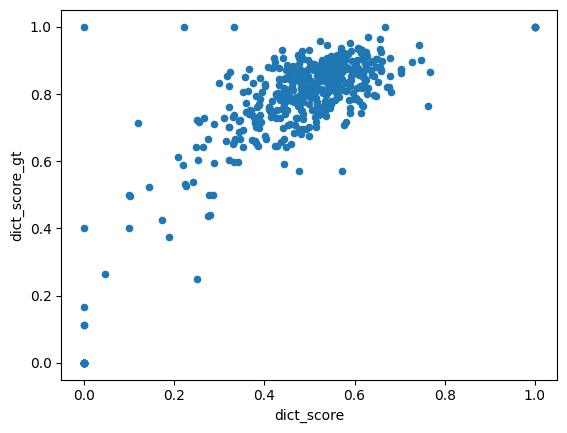

In [377]:
judgements.plot(kind="scatter", x="dict_score", y="dict_score_gt")
# TODO: dot size per text length


### Tri-gram Scores

In [378]:
MAX_N_GRAMS = 1000


judgements["n_gram_score"] = judgements.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams[:MAX_N_GRAMS])
)
judgements.iloc[judgements.n_gram_score.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_4,error_type_5,path,pagexml,lines,text,tokens,dict_score,dict_score_gt,n_gram_score
262,263,Slecht,NaN,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_3511_0260,3511,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_3511_0260.j...,"[6./, ƒ: 1 1, 1176. 8 7or: Aan t Compl: Bengal...",6./\nƒ: 1 1\n1176. 8 7or: Aan t Compl: Bengale...,"[./, ƒ, , , 176., , or:, Aan, t, Compl, Bengal...",0.289157,0.594378,0.000000
316,317,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_4418_0340,4418,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4418_0340.j...,[ee eee],ee eee,"[ee, eee]",0.000000,0.400000,0.000000
279,280,Goed,NaN,1,medium,leeg; transcriptie die er niet hoort,2,3,NL-HaNA_1.04.02_3652_0825,3652,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_3652_0825.j...,[eee e],eee e,"[eee, e]",0.250000,0.250000,0.000000
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4426_0769.j...,"[„, _]",„\n_,"[, ]",0.000000,0.000000,0.000000
319,320,Goed,NaN,1,medium,transcriptie,2,3,NL-HaNA_1.04.02_4444_0535,4444,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4444_0535.j...,"[Aan de Edele Achtbaare, Heeren Bewindhebberen...",Aan de Edele Achtbaare\nHeeren Bewindhebberen\...,"[Aan, de, Edele, Achtbaare, Heeren, Bewindhebb...",0.550000,0.816667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,112,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1988_1109,1988,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1988_1109.j...,[Van nadien het van oudsher een gebruijk gewee...,Van nadien het van oudsher een gebruijk gewees...,"[Van, nadien, het, van, oudsher, een, gebruijk...",0.655963,0.963303,0.228500
336,337,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_7893_0137,7893,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_7893_0137.j...,"[Iavas Oostcust den 27:e Iunij 1743, Mijn heer...",Iavas Oostcust den 27:e Iunij 1743\nMijn heer....,"[Iavas, Oostcust, den, 7:e, Iunij, 743, Mijn, ...",0.502216,0.874446,0.231342
43,44,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1400_1066,1400,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1400_1066.j...,[Ick op mijn aenkomst vondleggen wel dertig pr...,Ick op mijn aenkomst vondleggen wel dertig pra...,"[Ick, op, mijn, aenkomst, vondleggen, wel, der...",0.678212,0.853631,0.232404
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10675_0578....,[tee],tee,[tee],1.000000,1.000000,0.540000


### Garbage Token Scores

In [379]:
judgements["garbage_score"] = judgements.tokens.apply(get_garbage_score)
judgements.iloc[judgements.garbage_score.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_5,path,pagexml,lines,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score
378,379,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8831_0064,8831,...,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8831_0064.j...,"[Van Cormandel den 18 aug 1719, tot fiscael en...",Van Cormandel den 18 aug 1719\ntot fiscael en\...,"[Van, Cormandel, den, 8, aug, 719, tot, fiscae...",0.534548,0.778284,0.161511,0.000000
85,86,Goed?,Heel veel van andere pagina's,0,slecht,NaN,3,3,NL-HaNA_1.04.02_1785_0028,1785,...,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1785_0028.j...,[agtb: gunst te continueren over den raad van ...,agtb: gunst te continueren over den raad van j...,"[agtb, gunst, te, continueren, over, den, raad...",0.742475,0.944482,0.192984,0.000000
387,388,Slecht,Tekst en regelherkenning,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_8960_0003,8960,...,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8960_0003.j...,"[ommis, Ge, Van, e Ven, M, Ce, Ge Ce, V: Cr, C...",ommis\nGe\nVan\ne Ven\nM\nCe\nGe Ce\nV: Cr\nCe...,"[ommis, Ge, Van, e, Ven, M, Ce, Ge, Ce, V, Cr,...",0.404762,0.666667,0.000000,0.000000
131,132,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2155_0281,2155,...,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2155_0281.j...,"[en palicoll buijten kennisse van, mooren teli...",en palicoll buijten kennisse van\nmooren telic...,"[en, palicoll, buijten, kennisse, van, mooren,...",0.524217,0.849003,0.098145,0.000000
388,389,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8970_1586,8970,...,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8970_1586.j...,"[Van Ceijlon onder dato 25 Septemb:r 1716, p. ...",Van Ceijlon onder dato 25 Septemb:r 1716\np. ....,"[Van, Ceijlon, onder, dato, 5, Septemb:r, 716,...",0.469930,0.728671,0.054318,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,437,Leeg,NaN,0,medium,leeg; 1 transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9594_0147,9594,...,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9594_0147.j...,"[6e 8, 9, eeeee, ve ee]",6e 8\n9\neeeee\nve ee,"[e, , , eeeee, ve, ee]",0.100000,0.500000,0.000000,0.166667
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...,"[ee, eve, ee, evee, e, een, 19, eeeee, eeee, e...",0.173448,0.426124,0.048968,0.178344
432,433,Leeg,NaN,0,medium,leeg; transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9467_0563,9467,...,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9467_0563.j...,"[eeere, eeeee, eve e en]",eeere\neeeee\neve e en,"[eeere, eeeee, eve, e, en]",0.187500,0.375000,0.194800,0.200000
337,338,Slecht,Layout,3,medium,leesvolgorde; ditto,2,5,NL-HaNA_1.04.02_7950_0317,7950,...,NaN,/Users/carstenschnober/LAHTeR/workspace/htr-qu...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_7950_0317.j...,"[Baguala, ten overstaan van dies Restherdiers,...","Baguala, ten overstaan van dies Restherdiers, ...","[Baguala, ten, overstaan, van, dies, Restherdi...",0.321101,0.700584,0.036578,0.211009


### Publication Year

In [380]:
judgements = judgements.join(
    years.set_index("inventory_number").groupby("inventory_number").first(),
    on="Invno",
    how="left",
    validate="many_to_one",
)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,dict_score,dict_score_gt,n_gram_score,garbage_score,title,handle,date_text,date_iso,year_begin,year_end
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,0.378567,0.712289,0.084309,0.002915,1618 dec. 16 (extract - resolutie),http://hdl.handle.net/10648/2d59b1cf-9a71-48e5...,1618,1618,1618.0,1618.0
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.428164,0.793615,0.098740,0.005540,"1634 VV. Eerste boek, vervolg",http://hdl.handle.net/10648/461ef09b-8a71-4dab...,1632 nov. 1 - 1633 aug. 9,1632-11-01/1633-08-09,1632.0,1633.0
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,0.315423,0.659038,0.078552,0.003407,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,0.321451,0.603502,0.067127,0.017182,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,0.173448,0.426124,0.048968,0.178344,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,0.569307,0.935644,0.120795,0.008197,None,http://hdl.handle.net/10648/d83032b1-6d77-423c...,1782,1782,1782.0,1782.0
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,0.604352,0.892186,0.174786,0.000000,None,http://hdl.handle.net/10648/909f985c-d2c7-49d2...,1754,1754,1754.0,1754.0
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,0.599502,0.786070,0.148869,0.015707,None,http://hdl.handle.net/10648/da351965-359d-4114...,1769,1769,1769.0,1769.0
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,0.557219,0.818182,0.172606,0.014085,None,http://hdl.handle.net/10648/f11bb836-5ccb-4244...,1776,1776,1776.0,1776.0


In [381]:
judgements.loc[judgements.year_begin.isna()]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,dict_score,dict_score_gt,n_gram_score,garbage_score,title,handle,date_text,date_iso,year_begin,year_end
297,298,Slecht,Layout,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_3995_0564,3995,...,0.224138,0.533575,0.008647,0.024077,None,http://hdl.handle.net/10648/83f2b8ef-6aa5-4f86...,1660 - 1661 [1661],None,NaN,NaN
299,300,Goed,NaN,1,medium,transcriptie,2,3,NL-HaNA_1.04.02_4001_1671,4001,...,0.413061,0.749017,0.095977,0.000000,None,http://hdl.handle.net/10648/030642fc-6d1f-4218...,1666 - 1667 [1667],None,NaN,NaN
300,301,Medium,Layout,2,medium,leesvolgorde,2,4,NL-HaNA_1.04.02_4002_0204,4002,...,0.486822,0.775194,0.049482,0.007299,None,http://hdl.handle.net/10648/1aa6a9ee-b698-40a6...,1667 - 1668 [1668],None,NaN,NaN
301,302,Slecht,Layout,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_4004_0872,4004,...,0.351598,0.694064,0.023801,0.036199,None,http://hdl.handle.net/10648/1898c3e7-3bb9-4048...,1668 - 1670 [1670],None,NaN,NaN
302,303,Slecht,Layout,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_4010_0734,4010,...,0.378265,0.658830,0.008490,0.024347,None,http://hdl.handle.net/10648/9d725e3a-56f4-482a...,1673 - 1674 [1674],None,NaN,NaN
310,311,Goed,NaN,1,medium,transcriptie,2,3,NL-HaNA_1.04.02_4362_0470,4362,...,0.659781,0.866950,0.127778,0.005848,"Bijlagen, eerste deel, eerste stuk",http://hdl.handle.net/10648/9844ccbc-bf5e-4bd0...,None,None,NaN,NaN
311,312,Medium,Marginalia,2,medium,leesvolgorde (marginalia),2,4,NL-HaNA_1.04.02_4373_0028,4373,...,0.570181,0.930154,0.152976,0.000000,None,http://hdl.handle.net/10648/06c9c4c3-a03c-469f...,1729 - 1731 [1730 - 1731],None,NaN,NaN
315,316,Slecht,Layout,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_4411_0729,4411,...,0.274576,0.437288,0.019048,0.019048,None,http://hdl.handle.net/10648/f94bf2b4-ab5b-46d0...,1772 - 1773 [1774],None,NaN,NaN
395,396,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_9013A_0208,9013A,...,0.535565,0.773013,0.085612,0.009709,Bestanddeel 1,http://hdl.handle.net/10648/7486ce75-b5a1-4995...,None,None,NaN,NaN


### Column Width

In [382]:
from statistics import mean


def average_line_length(page: pagexml) -> float:
    lengths = [len(line.text) for line in page.get_lines() if line.text is not None]
    return mean(lengths) if lengths else 0


In [383]:
judgements["column_width"] = judgements.pagexml.apply(average_line_length)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,dict_score_gt,n_gram_score,garbage_score,title,handle,date_text,date_iso,year_begin,year_end,column_width
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,0.712289,0.084309,0.002915,1618 dec. 16 (extract - resolutie),http://hdl.handle.net/10648/2d59b1cf-9a71-48e5...,1618,1618,1618.0,1618.0,47.534884
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.793615,0.098740,0.005540,"1634 VV. Eerste boek, vervolg",http://hdl.handle.net/10648/461ef09b-8a71-4dab...,1632 nov. 1 - 1633 aug. 9,1632-11-01/1633-08-09,1632.0,1633.0,44.872340
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,0.659038,0.078552,0.003407,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0,53.462687
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,0.603502,0.067127,0.017182,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0,36.576923
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,0.426124,0.048968,0.178344,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0,5.225490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,0.935644,0.120795,0.008197,None,http://hdl.handle.net/10648/d83032b1-6d77-423c...,1782,1782,1782.0,1782.0,31.304348
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,0.892186,0.174786,0.000000,None,http://hdl.handle.net/10648/909f985c-d2c7-49d2...,1754,1754,1754.0,1754.0,35.382353
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,0.786070,0.148869,0.015707,None,http://hdl.handle.net/10648/da351965-359d-4114...,1769,1769,1769.0,1769.0,18.358491
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,0.818182,0.172606,0.014085,None,http://hdl.handle.net/10648/f11bb836-5ccb-4244...,1776,1776,1776.0,1776.0,35.181818


### Words per Text Region

In [384]:
def words_per_region(page: pagexml) -> float:
    words = [region.stats["words"] for region in page.text_regions]
    return mean(words) if words else 0


In [385]:
judgements["words_per_region"] = judgements.pagexml.apply(words_per_region)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,n_gram_score,garbage_score,title,handle,date_text,date_iso,year_begin,year_end,column_width,words_per_region
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,0.084309,0.002915,1618 dec. 16 (extract - resolutie),http://hdl.handle.net/10648/2d59b1cf-9a71-48e5...,1618,1618,1618.0,1618.0,47.534884,114.333333
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.098740,0.005540,"1634 VV. Eerste boek, vervolg",http://hdl.handle.net/10648/461ef09b-8a71-4dab...,1632 nov. 1 - 1633 aug. 9,1632-11-01/1633-08-09,1632.0,1633.0,44.872340,120.333333
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,0.078552,0.003407,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0,53.462687,196.000000
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,0.067127,0.017182,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0,36.576923,36.375000
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,0.048968,0.178344,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0,5.225490,2.661017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,0.120795,0.008197,None,http://hdl.handle.net/10648/d83032b1-6d77-423c...,1782,1782,1782.0,1782.0,31.304348,122.000000
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,0.174786,0.000000,None,http://hdl.handle.net/10648/909f985c-d2c7-49d2...,1754,1754,1754.0,1754.0,35.382353,201.000000
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,0.148869,0.015707,None,http://hdl.handle.net/10648/da351965-359d-4114...,1769,1769,1769.0,1769.0,18.358491,63.666667
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,0.172606,0.014085,None,http://hdl.handle.net/10648/f11bb836-5ccb-4244...,1776,1776,1776.0,1776.0,35.181818,53.250000


## Preprocessing and Filtering

In [386]:
judgements["quality"] = np.ceil(judgements.Som / 2).astype(int)
judgements.iloc[judgements.quality.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,garbage_score,title,handle,date_text,date_iso,year_begin,year_end,column_width,words_per_region,quality
192,193,Gedrukt?!,NaN,0,onbekend,gedrukte pagina,0,0,NL-HaNA_1.04.02_2659_0164,2659,...,0.006452,"1747. NNNNNNN. Derde boek: Batavia, derde deel",http://hdl.handle.net/10648/12c59204-ddf3-4254...,1747,1747,1747.0,1747.0,32.288462,31.500000,0
151,152,goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2314_1588,2314,...,0.019139,1735. AAAAAAA. Negentiende boek: Batavia's in...,http://hdl.handle.net/10648/cba0d4d6-e731-44f4...,1735,1735,1735.0,1735.0,36.176471,41.800000,1
392,393,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8990_0164,8990,...,0.019231,"Malabar, 1703 nov. 1 - 1704 juni 22; Bantam, ...",http://hdl.handle.net/10648/a489c83a-0405-4791...,1704 jan. 30 - 1705 feb. 28,1704-01-30/1705-02-28,1704.0,1705.0,38.909091,104.000000,1
180,181,goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2579_0251,2579,...,0.011236,1743. IIIIIII. Dertigste boek: Batavia's inge...,http://hdl.handle.net/10648/582bb146-026b-4a83...,1743,1743,1743.0,1743.0,20.409091,29.666667,1
181,182,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2585_0213,2585,...,0.009009,1743. IIIIIII. Zesendertigste boek: Batavia's ...,http://hdl.handle.net/10648/8223dd99-0341-4803...,1743,1743,1743.0,1743.0,32.611111,111.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,373,Slecht,Regio-indeling,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_8784_0928,8784,...,0.035088,None,http://hdl.handle.net/10648/0c39795f-e315-4fd7...,1738 jan. 23 - sep. 4,1738-01-23/1738-09-04,1738.0,1738.0,30.805556,57.000000,3
215,216,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_3010_0357,3010,...,0.054363,1762. Dertiende boek: Coromandel,http://hdl.handle.net/10648/df43f6c7-acdc-498e...,1762,1762,1762.0,1762.0,37.750000,53.769231,3
219,220,Slecht,NaN,3,medium,layout; leesvolgorde,2,5,NL-HaNA_1.04.02_3018_0173,3018,...,0.023861,"1762. Eenentwintigste boek: Ceylon, achtste deel",http://hdl.handle.net/10648/1f0e9e8d-fd56-4479...,1762,1762,1762.0,1762.0,34.338983,41.909091,3
394,395,Slecht,Regelherkenning en indeling,3,slecht,leesvolgorde; layout,3,6,NL-HaNA_1.04.02_9009_0451,9009,...,0.100358,None,http://hdl.handle.net/10648/dda64dff-9bd1-4902...,1727 apr. 30 - juli 26,1727-04-30/1727-07-26,1727.0,1727.0,40.266667,93.000000,3


In [387]:
judgements["Opmerkingen Kay"].unique()


array(['Tekst', nan, 'Leesvolgorde en tekst', 'Leesvolgorde',
       'leesvolgorde', 'Layout', 'Regiovolgorde', 'layout', 'Amanetchan!',
       'tekst', "Heel veel van andere pagina's",
       'Zowel lees als tekst medium', 'Leesvolgorde/Layout',
       'Laout/Leesvolgorde', 'Lay out', 'Baselines', 'Marginalia',
       'Regelvolgorde', 'Layout, tekst', 'Regioherkenning',
       'Herkennen van regels', 'Regio indeling', 'Layout/Regelherkenning',
       'Regioherkenning en volgorde', 'Regelindeling', 'marginalia',
       'Regio-indeling', 'Regioindeling', 'Regelherkenning',
       'Tekst en regelherkenning', 'Regelherkenning en indeling',
       'Regioherkenning/Volgorde', 'Regiovolgorde en herkenning',
       'Regelvolgorde en herkenning',
       "Layout twee pagina's niet goed gedetecteerd", 'Regiodetectie',
       'Regio/Regeldetectie', 'Regiodetectie/Volgorde'], dtype=object)

In [388]:
judgements["Opmerkingen Maartje"].unique()


array([nan, 'leeg', 'leeg; transcriptie die er niet hoort',
       'leesvolgorde (marginalia)', 'layout', 'leesvolgorde',
       'transcriptie', 'layout; leesvolgorde',
       'leesvolgorde + transcriptie',
       'leesvolgorde prima als andere pagina wordt weggedacht',
       'gedrukte pagina', 'layout (marginalia)',
       'leesvolgorde eerste regel alinea ', 'ditto teken', 'marginalia',
       'transcriptie; leesvolgorde', 'transcriptie ',
       'leesvolgorde; transcriptie', 'leesvolgorde; layout',
       'extra pagina er onder gescand', 'leesvolgorde; ditto',
       'leestekens', 'handtekening', 'leeg; transcriptie die er niet is',
       'leeg; 1 transcriptie die er niet is', 'leesvolgorde; cijfers',
       'leeg; 1 transcriptie', 'leestekens, leesvolgorde',
       'moeite met getallen'], dtype=object)

In [389]:
non_empty = judgements.loc[(judgements.text.str.len() > 0) & (judgements.Som > 0)]
agreement = judgements.loc[judgements["Ranking Kay"] == judgements["Ranking Maartje"]]
has_year_begin = judgements.loc[judgements.year_begin.notna()]
non_layout = judgements[
    ~(
        (judgements["Opmerkingen Maartje"].str.lower().str.contains("layout"))
        | (judgements["Opmerkingen Kay"].str.lower().str.contains("layout"))
        | (judgements["Opmerkingen Maartje"].str.lower().str.contains("volgorde"))
        | (judgements["Opmerkingen Kay"].str.lower().str.contains("volgorde"))
    )
]


filtered = judgements.iloc[
    non_empty.index.intersection(agreement.index)
    # .intersection(has_year_begin.index)
    # .intersection(non_layout.index)
]
filtered


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,garbage_score,title,handle,date_text,date_iso,year_begin,year_end,column_width,words_per_region,quality
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,0.002915,1618 dec. 16 (extract - resolutie),http://hdl.handle.net/10648/2d59b1cf-9a71-48e5...,1618,1618,1618.0,1618.0,47.534884,114.333333,2
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.005540,"1634 VV. Eerste boek, vervolg",http://hdl.handle.net/10648/461ef09b-8a71-4dab...,1632 nov. 1 - 1633 aug. 9,1632-11-01/1633-08-09,1632.0,1633.0,44.872340,120.333333,1
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,0.003407,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0,53.462687,196.000000,3
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,0.017182,"1634 VV. Tweede boek, vervolg",http://hdl.handle.net/10648/dc1908ac-97e5-4ea4...,1634,1634,1634.0,1634.0,36.576923,36.375000,2
5,6,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1111_0725,1111,...,0.008772,1635. WW. Eerste boek,http://hdl.handle.net/10648/b3055066-83f7-4905...,1633 nov. 24 - 1634 dec. 4,1633-11-24/1634-12-04,1633.0,1634.0,44.869565,68.600000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,491,Goed,NaN,1,goed,ditto teken,1,2,NL-HaNA_1.04.02_10871_0141,10871,...,0.026718,None,http://hdl.handle.net/10648/70985920-f58c-47be...,1748,1748,1748.0,1748.0,34.555556,52.400000,1
491,492,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_10884_0593,10884,...,0.025641,None,http://hdl.handle.net/10648/990228bb-0726-4583...,1766,1766,1766.0,1766.0,25.741935,19.500000,3
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,0.008197,None,http://hdl.handle.net/10648/d83032b1-6d77-423c...,1782,1782,1782.0,1782.0,31.304348,122.000000,1
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,0.000000,None,http://hdl.handle.net/10648/909f985c-d2c7-49d2...,1754,1754,1754.0,1754.0,35.382353,201.000000,1


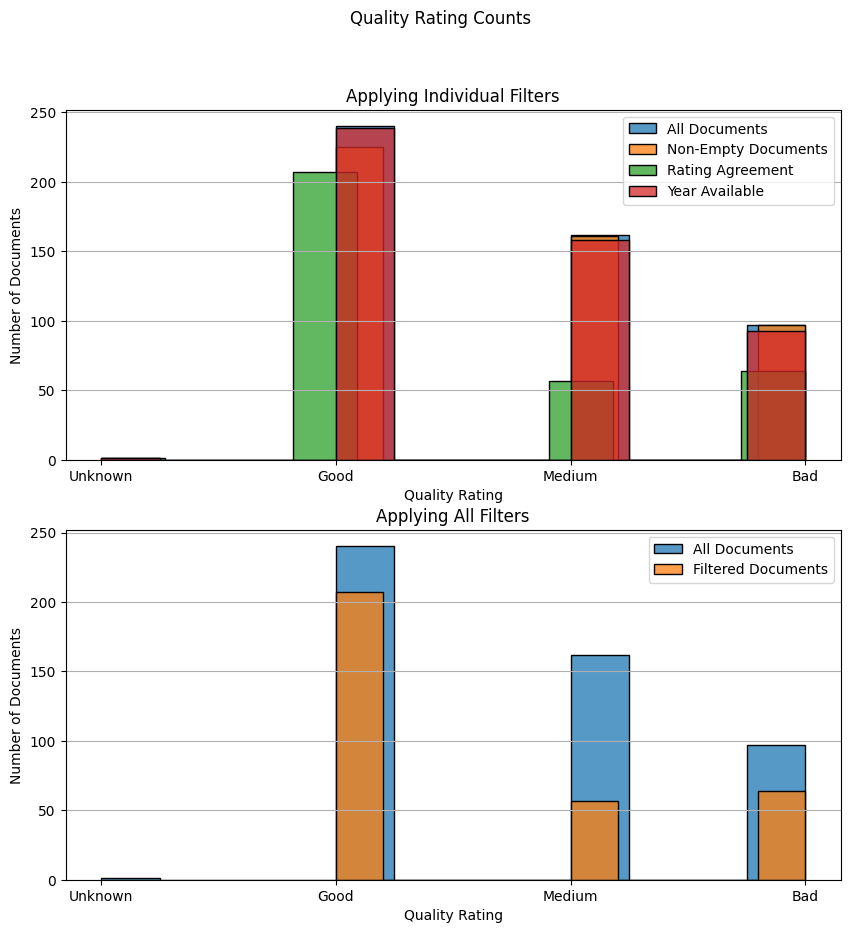

In [390]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10), sharex=False, sharey=True)


fig.suptitle("Quality Rating Counts")

sns.color_palette("tab10")

ax1.set_title("Applying Individual Filters")
sns.histplot(judgements.quality, label="All Documents", ax=ax1)
sns.histplot(non_empty.quality, label="Non-Empty Documents", ax=ax1)
sns.histplot(agreement.quality, label="Rating Agreement", ax=ax1)
# sns.histplot(non_layout.quality, label="Non-Layout Issue", ax=ax1)
sns.histplot(has_year_begin.quality, label="Year Available", ax=ax1)

ax2.set_title("Applying All Filters")
sns.histplot(judgements.quality, label="All Documents", ax=ax2)
sns.histplot(filtered.quality, label="Filtered Documents", ax=ax2)

for ax in (ax1, ax2):
    ax.grid(axis="y")
    ax.set_ylabel("Number of Documents")
    ax.set_xlabel("Quality Rating")
    ax.set_xticks(range(4))
    ax.set_xticklabels(["Unknown", "Good", "Medium", "Bad"])

    ax.legend()


## Plot Features

In [391]:
x_fields = [
    "dict_score",
    "dict_score_gt",
    "n_gram_score",
    "garbage_score",
    # "column_width",
    # "words_per_region",
    # "year_begin",
]

y_field = "quality"


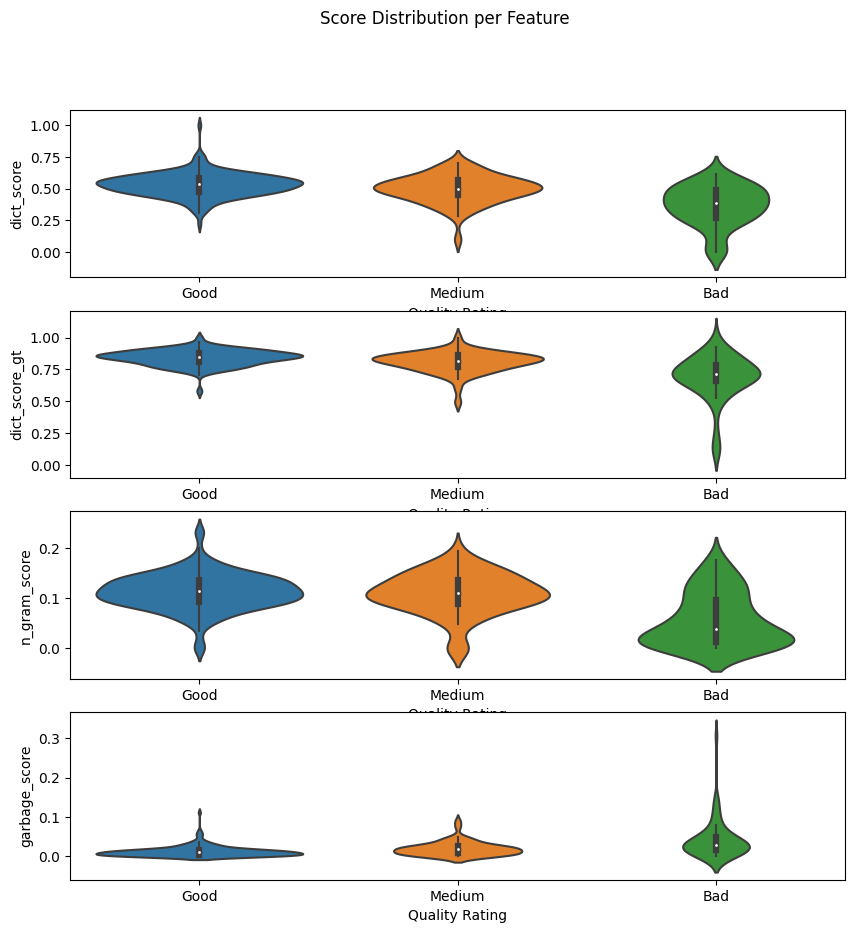

In [392]:
fig, axs = plt.subplots(
    nrows=len(x_fields), figsize=(10, 10), sharex=False, sharey=False
)


fig.suptitle("Score Distribution per Feature")

for ax, column in zip(axs, x_fields):
    sns.violinplot(x=filtered.quality, y=filtered[column], ax=ax)

    ax.set_ylabel(column)
    ax.set_xlabel("Quality Rating")
    ax.set_xticks(range(3))
    ax.set_xticklabels(["Good", "Medium", "Bad"])


## Classify

### Normalize Features

In [393]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(filtered[x_fields])
scaler


StandardScaler()

In [394]:
filtered[x_fields]


,dict_score,dict_score_gt,n_gram_score,garbage_score
0,0.378567,0.712289,0.084309,0.002915
1,0.428164,0.793615,0.098740,0.005540
2,0.315423,0.659038,0.078552,0.003407
3,0.321451,0.603502,0.067127,0.017182
5,0.418023,0.740698,0.112956,0.008772
...,...,...,...,...
490,0.601751,0.863239,0.088985,0.026718
491,0.485714,0.724370,0.054590,0.025641
495,0.569307,0.935644,0.120795,0.008197
496,0.604352,0.892186,0.174786,0.000000


In [395]:
X = pd.DataFrame(scaler.transform(filtered[x_fields]), columns=x_fields)
X


,dict_score,dict_score_gt,n_gram_score,garbage_score
0,-0.919415,-0.842117,-0.368276,-0.585844
1,-0.526807,-0.123507,-0.054221,-0.488168
2,-1.419264,-1.312652,-0.493568,-0.567546
3,-1.371546,-1.803379,-0.742209,-0.054925
4,-0.607082,-0.591091,0.255177,-0.367902
...,...,...,...,...
323,0.847299,0.491704,-0.266518,0.299925
324,-0.071241,-0.735368,-1.015063,0.259863
325,0.590476,1.131490,0.425777,-0.389307
326,0.867893,0.747490,1.600794,-0.694339


In [396]:
y = filtered[y_field]
y.value_counts()


1    207
3     64
2     57
Name: quality, dtype: int64

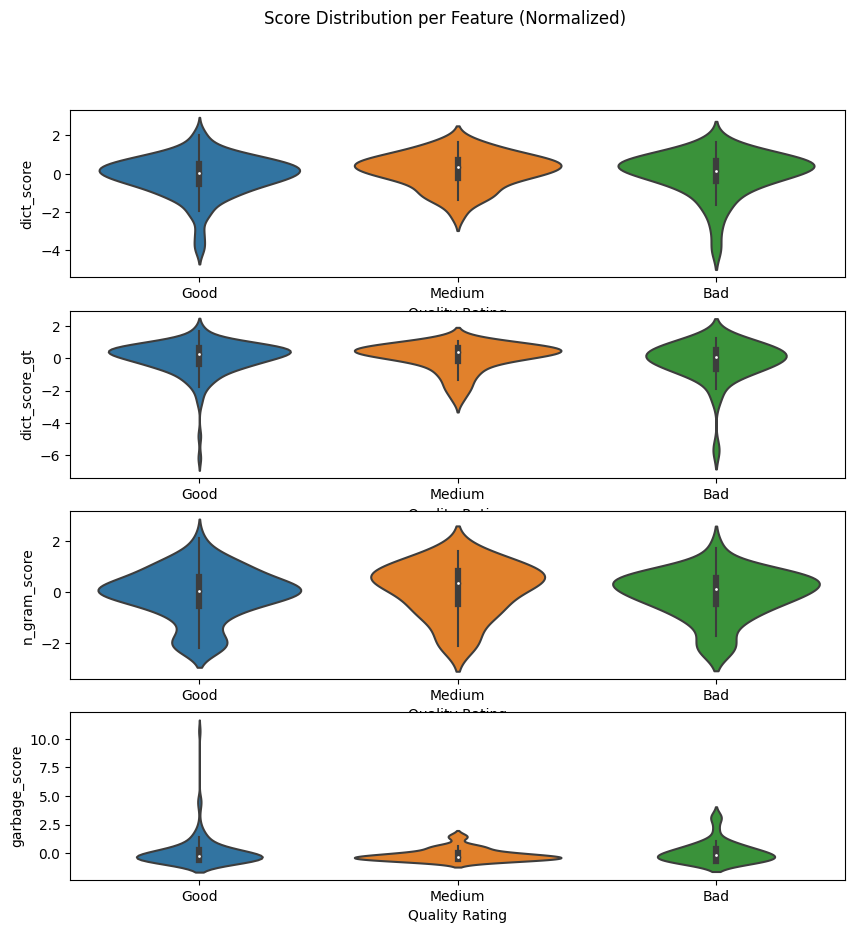

In [397]:
fig, axs = plt.subplots(
    nrows=len(x_fields), figsize=(10, 10), sharex=False, sharey=False
)

fig.suptitle("Score Distribution per Feature (Normalized)")

for ax, column in zip(axs, x_fields):
    sns.violinplot(x=filtered.quality, y=X[column], ax=ax)

    ax.set_ylabel(column)
    ax.set_xlabel("Quality Rating")
    ax.set_xticks(range(3))
    ax.set_xticklabels(["Good", "Medium", "Bad"])


### Feature Selection

In [398]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

model = SelectKBest(f_classif, k=3)
model.fit_transform(X, y)

{feature: p for feature, p in zip(x_fields, model.pvalues_)}


{'dict_score': 5.210712381361755e-21,
 'dict_score_gt': 6.425184263510816e-23,
 'n_gram_score': 8.426687355424829e-20,
 'garbage_score': 1.6048204856147136e-13}

In [399]:
from sklearn.feature_selection import SelectFwe
from sklearn.feature_selection import f_classif

model = SelectFwe(f_classif)
model.fit_transform(X, y)
{feature: p for feature, p in zip(x_fields, model.pvalues_)}


{'dict_score': 5.210712381361755e-21,
 'dict_score_gt': 6.425184263510816e-23,
 'n_gram_score': 8.426687355424829e-20,
 'garbage_score': 1.6048204856147136e-13}

In [400]:
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import chi2

model = SelectFdr()
model.fit_transform(X, y)
model.pvalues_


array([5.21071238e-21, 6.42518426e-23, 8.42668736e-20, 1.60482049e-13])

### KNN

In [401]:
from sklearn.neighbors import KNeighborsClassifier


n = 5

knn_classifier = KNeighborsClassifier(n_neighbors=n)


In [402]:
from sklearn import model_selection

scores = model_selection.cross_val_score(knn_classifier, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)


0.72 accuracy with a standard deviation of 0.01


In [403]:
column = "prediction_knn"

filtered[column] = model_selection.cross_val_predict(knn_classifier, X, y)


/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_70879/1330561670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(knn_classifier, X, y)


In [404]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_knn': 0.7143


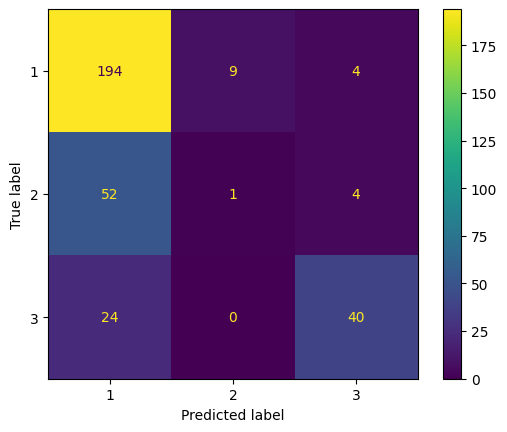

In [405]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(filtered[y_field], filtered[column])


In [406]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.3651877133105802

### Decision Tree

In [407]:
from sklearn import tree

max_depth = 3

decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth)


In [408]:
from sklearn import model_selection

scores = model_selection.cross_val_score(decision_tree, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)


0.67 accuracy with a standard deviation of 0.04


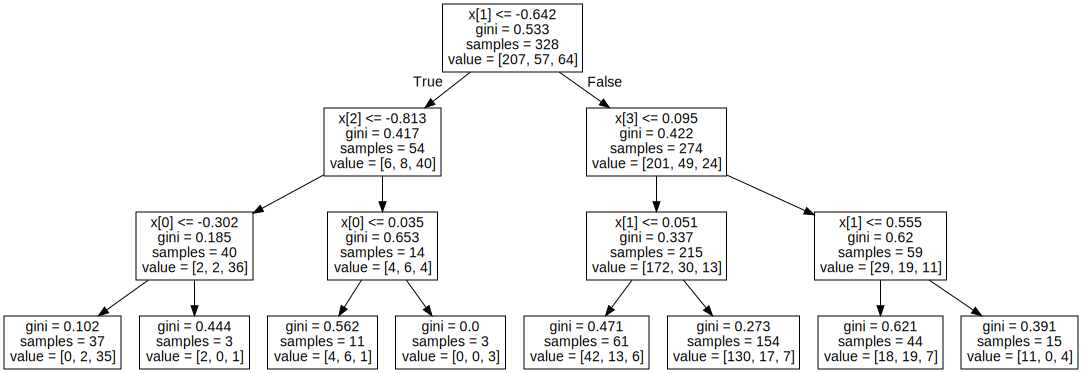

In [409]:
import graphviz
from sklearn.model_selection import train_test_split

decision_tree.fit(X, y)

dot_data = tree.export_graphviz(decision_tree, out_file=None)
graph = graphviz.Source(dot_data)
graph


### Random Forest

In [410]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(max_depth=max_depth)


In [411]:
from sklearn import model_selection

scores = model_selection.cross_val_score(random_forest, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)


0.74 accuracy with a standard deviation of 0.03


In [412]:
column = "prediction_random_forest"

filtered[column] = model_selection.cross_val_predict(random_forest, X, y)


/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_70879/4095977255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(random_forest, X, y)


In [413]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_random_forest': 0.6724


In [414]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.38444669365721995

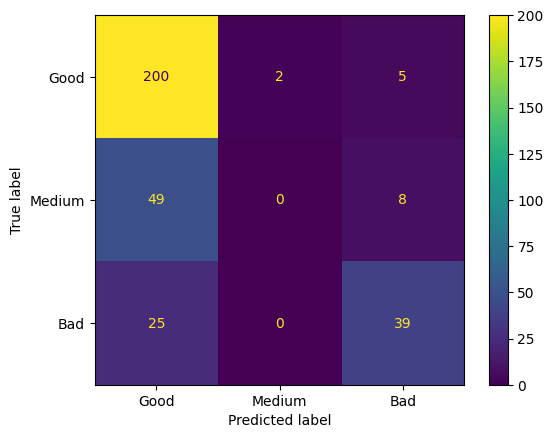

In [415]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(
    filtered[y_field], filtered[column], display_labels=["Good", "Medium", "Bad"]
)


### SVM

In [416]:
from sklearn import svm

svm_classifier = svm.SVC()


In [417]:
from sklearn import model_selection

scores = model_selection.cross_val_score(svm_classifier, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)


0.72 accuracy with a standard deviation of 0.03


In [418]:
column = "prediction_svm"

filtered[column] = model_selection.cross_val_predict(svm_classifier, X, y)


/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_70879/529513167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(svm_classifier, X, y)


In [419]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_svm': 0.6355


In [420]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.3416672120775792

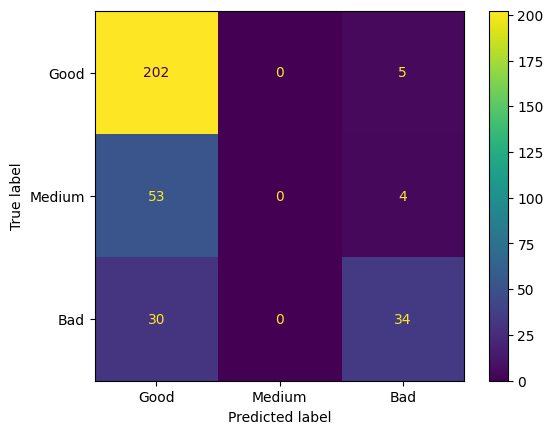

In [421]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(
    filtered[y_field], filtered[column], display_labels=["Good", "Medium", "Bad"]
)


### Multi-layer Perceptron

In [422]:
from sklearn import neural_network

nn = neural_network.MLPClassifier(
    hidden_layer_sizes=(
        32,
        16,
    ),
    #learning_rate="adaptive",
    #max_iter=1000,
)


In [423]:
scores = model_selection.cross_val_score(nn, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

0.73 accuracy with a standard deviation of 0.02


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [424]:
column = "prediction_nn"

filtered[column] = model_selection.cross_val_predict(nn, X, y)


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

In [425]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.38171536286522145

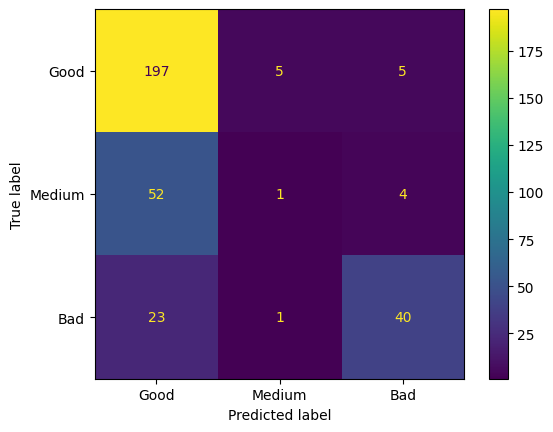

In [426]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(
    filtered[y_field], filtered[column], display_labels=["Good", "Medium", "Bad"]
)


In [427]:
from sklearn import metrics

precision = metrics.precision_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"Precision for bad quality pages with '{column}': {precision:.4}")


Precision for bad quality pages with 'prediction_nn': 0.8163


In [428]:
from sklearn import metrics

recall = metrics.recall_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"Recall for bad quality pages with '{column}': {recall:.4}")


Recall for bad quality pages with 'prediction_nn': 0.625


In [429]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_nn': 0.708


### Analysis

In [430]:
filtered.loc[(filtered.prediction_nn == 1) & (filtered[y_field] == 3)]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,date_iso,year_begin,year_end,column_width,words_per_region,quality,prediction_knn,prediction_random_forest,prediction_svm,prediction_nn
108,109,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1968_0696,1968,...,1723,1723.0,1723.0,2.000000,1.000000,3,1,1,1,1
117,118,Slecht,Layout,3,slecht,layout,3,6,NL-HaNA_1.04.02_2036_0307,2036,...,1727,1727.0,1727.0,15.960000,20.125000,3,1,1,1,1
171,172,Slecht,Leesvolgorde,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_2438_1347,2438,...,1739,1739.0,1739.0,27.354839,22.357143,3,1,1,1,1
204,205,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_2778_0747,2778,...,1752,1752.0,1752.0,28.589744,48.400000,3,1,1,1,1
215,216,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_3010_0357,3010,...,1762,1762.0,1762.0,37.750000,53.769231,3,1,1,1,1
272,273,Slecht,NaN,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_3580_0688,3580,...,1781,1781.0,1781.0,27.038961,33.583333,3,1,1,1,1
293,294,Slecht,Layout,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_3915_0293,3915,...,1792,1792.0,1792.0,35.544304,38.923077,3,1,1,1,1
307,308,Slecht,"Layout, tekst",3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_4313_0120,4313,...,1784/1785,1784.0,1785.0,28.010526,58.777778,3,1,1,1,1
323,324,Slecht,Layout,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_4448_0474,4448,...,1690/1697,1690.0,1697.0,27.285714,18.727273,3,1,1,1,1
324,325,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_4449_0680,4449,...,1698/1720,1698.0,1720.0,22.846154,17.583333,3,1,1,1,1


In [431]:
filtered.loc[(filtered.prediction_nn == 3) & (filtered.quality == 1)][
    ["Filename", "tokens", "text"]
]


,Filename,tokens,text
32,NL-HaNA_1.04.02_1302_0976,"[de, posten, raackende, uEE, ende, dit, Compto...",de posten raackende uEE ende dit Comptoir sull...
152,NL-HaNA_1.04.02_2320_1605,"[Van, Mallabaar, onder, dato, 4=e, april, 7346...",Van Mallabaar onder dato 24=e april 17346\nafg...
163,NL-HaNA_1.04.02_2413_0460,"[Van, Ceijlon, onder, dato, 9:', Ianuarij, 737...",Van Ceijlon onder dato 19:' Ianuarij 1737.\nal...
291,NL-HaNA_1.04.02_3884_0332,"[nagezien, Pompeu]",nagezien\nPompeu:
433,NL-HaNA_1.04.02_9496_0630,"[Nagezien, E, W„m, Louis, Een, Berigt, van, de...",Nagezien\nE„ W„m Louis\nEen Berigt van de Comm...


In [432]:
filtered.loc[(filtered.prediction_nn == 1) & (filtered.quality == 3)][
    ["Filename", "tokens", "text"]
]


,Filename,tokens,text
108,NL-HaNA_1.04.02_1968_0696,[:],1:
117,NL-HaNA_1.04.02_2036_0307,"[uytslag, van, saken, tot, tyd, en, inslateur,...",uytslag van saken tot tyd en\ninslateur\nS —\n...
171,NL-HaNA_1.04.02_2438_1347,"[Van, Riam, onder, dato, 11, antw:t, eeree, Om...",Van Riam onder dato 311\nantw:t\n--\neeree\nOm...
204,NL-HaNA_1.04.02_2778_0747,"[Van, Banda, onder, dato, , Jbr, A„j, 751, boe...",Van Banda onder dato 8 Jbr A„j 1751\nboekhoude...
215,NL-HaNA_1.04.02_3010_0357,"[64.—, , ., ., Packen, Per, Transport, met, P,...",164.— „ 2. -. Packen Per Transport met P o/ 15...
272,NL-HaNA_1.04.02_3580_0688,"[Nagezie, e, ere, i, J„r, V„r, Ole, Lasten, in...",Nagezie\ne ere\ni\nJ„r V„r Ole\nLasten in dit ...
293,NL-HaNA_1.04.02_3915_0293,"[boven, hunne, waarde, zijn, uijtgegeeven, van...",boven hunne waarde zijn uijtgegeeven van uwelE...
307,NL-HaNA_1.04.02_4313_0120,"[1., 0, En, met, erst, op, het, hem, van, zyne...",11. 10 En met erst op het hem van zynen Broede...
323,NL-HaNA_1.04.02_4448_0474,"[566, a, 577, dito, missive, als, vooren, in, ...",1566 a 1577 dito missive als vooren in dato 11...
324,NL-HaNA_1.04.02_4449_0680,"[93, 939, 90, a, 59, , 62, 63, a, 69, 65, a, 6...",993 1939\n990 a\n959 „ 962\n963 a 469\n965 a 5...


In [434]:
filtered.loc[filtered.prediction_nn != filtered.prediction_knn][
    [y_field] + ["prediction_nn", "prediction_knn", "text", "tokens", "Filename"]
]


,quality,prediction_nn,prediction_knn,text,tokens,Filename
9,1,1,2,18\nWij Confirmeren met 8: edh=t ende is seeck...,"[8, Wij, Confirmeren, met, :, edh=t, ende, is,...",NL-HaNA_1.04.02_1131_0054
43,1,2,1,Ick op mijn aenkomst vondleggen wel dertig pra...,"[Ick, op, mijn, aenkomst, vondleggen, wel, der...",NL-HaNA_1.04.02_1400_1066
80,1,2,1,js dat vaertuijgh op Cranganoor gearresteert\n...,"[js, dat, vaertuijgh, op, Cranganoor, gearrest...",NL-HaNA_1.04.02_1757_0786
152,1,3,2,Van Mallabaar onder dato 24=e april 17346\nafg...,"[Van, Mallabaar, onder, dato, 4=e, april, 7346...",NL-HaNA_1.04.02_2320_1605
252,1,1,2,280\nop heeden den 23 Maart 1711. Compareerde ...,"[80, op, heeden, den, 3, Maart, 711., Comparee...",NL-HaNA_1.04.02_3330_0390
303,1,1,2,"p„s,\n. Co\nSententie van\nJacobus de Bruy","[p„s, , Co, Sententie, van, Jacobus, de, Bruy]",NL-HaNA_1.04.02_4071_1018
354,1,1,2,van Timor den 2=' Septemb=r A=o 1703. —\ncogel...,"[van, Timor, den, =', Septemb=r, A=o, 703., , ...",NL-HaNA_1.04.02_8314_0347
391,1,1,3,"Van Ceijlon, onderdato 19:' febr: 1741.——\ngro...","[Van, Ceijlon, onderdato, 9:', febr, 741.——, g...",NL-HaNA_1.04.02_8980_1908
419,2,2,1,Copia\nRegister der stucken\nprofiso rat: off:...,"[Copia, Register, der, stucken, profiso, rat, ...",NL-HaNA_1.04.02_9358_0188
427,2,1,2,ve e e\n„ 13. —\nC. — Den onderhandse verklari...,"[ve, e, e, , 3., , C, , Den, onderhandse, verk...",NL-HaNA_1.04.02_9424_0784


In [435]:
error_type_columns = ["error_type_" + str(i) for i in range(1, 6)]
prediction_columns = [
    column for column in filtered.columns if column.startswith("prediction")
]

filtered.loc[
    filtered[error_type_columns].notna().all(axis="columns")
    & (filtered.quality != filtered.prediction_nn)
][error_type_columns + prediction_columns + ["quality"]]


,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,prediction_knn,prediction_random_forest,prediction_svm,prediction_nn,quality
170,13.0,0.0,1.0,2.0,0.0,3,3,3,3,2
220,1.0,1.0,2.0,3.0,0.0,1,1,1,1,2
281,5.0,2.0,3.0,4.0,0.0,1,1,1,1,2
294,1.0,1.0,1.0,1.0,0.0,1,1,1,1,2


# Test on HTR data

## Pipeline

In [436]:
classifier = nn.fit(X, y)
classifier


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(32, 16))

In [437]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("scaler", scaler), ("classifier", classifier)])
pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', MLPClassifier(hidden_layer_sizes=(32, 16)))])

In [438]:
assert (scaler.get_feature_names_out() == classifier.feature_names_in_).all()


In [439]:
from joblib import dump

PIPELINE_FILE = DATA_DIR / "pipeline_nn.joblib"
if PIPELINE_FILE.exists():
    raise FileExistsError(PIPELINE_FILE)
dump(pipeline, PIPELINE_FILE)


FileExistsError: /Users/carstenschnober/LAHTeR/workspace/htr-quality-classifier/text_quality/data/pipeline_nn.joblib

### Random Lines

In [440]:
RESULTS_FILE = DATA_DIR / "allresults.tar.bz2"
assert RESULTS_FILE.is_file()

ENCODING = "UTF-8"
TOTAL_FILES = 6873
LINES_PER_FILE = 10000


In [441]:
import tarfile
import random


OUTPUT_LINES = 10000

total_lines = TOTAL_FILES * LINES_PER_FILE

# line_numbers = set(random.choices(range(total_lines), k=OUTPUT_LINES))
# file_numbers = {int(line / LINES_PER_FILE) for line in line_numbers}

random_threshold = 1 - (OUTPUT_LINES / total_lines)

random_threshold


0.9998545031281827

In [442]:
from tqdm import tqdm

lines = []

with tqdm(total=OUTPUT_LINES, unit="line", desc="Reading") as pbar, tarfile.open(
    RESULTS_FILE, "r:bz2"
) as tar:
    for tarinfo in tar:
        if len(lines) >= OUTPUT_LINES:
            break
        for line in tar.extractfile(tarinfo):
            if len(lines) >= OUTPUT_LINES:
                break
            if random.random() > random_threshold:
                lines.append(line.decode(ENCODING))
                pbar.update()


lines


Reading: 100%|██████████| 10000/10000 [04:15<00:00, 39.17line/s]


['/data/globalise/1.04.02/10000/imagesnippets/NL-HaNA_1.04.02_10000_0252/NL-HaNA_1.04.02_10000_0252.xml-line_8769b2c8-50ae-424a-bac8-bfa30e1ea91b.png\t0.71865463\tsteld.\n',
 '/data/globalise/1.04.02/10002/imagesnippets/NL-HaNA_1.04.02_10002_0009/NL-HaNA_1.04.02_10002_0009.xml-line_7be70f5d-92bd-479e-8a18-2f3d206fd2c5.png\t0.25572622\tonder anderen, dat wel gem: hun Ed:s\n',
 '/data/globalise/1.04.02/10002/imagesnippets/NL-HaNA_1.04.02_10002_0169/NL-HaNA_1.04.02_10002_0169.xml-line_7247c531-53ec-4f52-ad8d-2332b4984dc5.png\t0.59136873\tafhandelen van eenige gewoone kom„\n',
 '/data/globalise/1.04.02/10003/imagesnippets/NL-HaNA_1.04.02_10003_0411/NL-HaNA_1.04.02_10003_0411.xml-line_1615e2d4-b0d3-4617-94d2-e21fe8f5743c.png\t0.033434223\t56 „ d=o dd=o ½ lb\n',
 '/data/globalise/1.04.02/10003/imagesnippets/NL-HaNA_1.04.02_10003_0205/NL-HaNA_1.04.02_10003_0205.xml-bedb4f58-b68d-45ba-ab5f-67d5cbe7cd72.png\t0.9241768\taanstonds aan de munt afgegeeven, tot het\n',
 '/data/globalise/1.04.02/1000

In [443]:
import os
from io import StringIO

results = (
    pd.read_csv(
        StringIO(os.linesep.join(lines)),
        delimiter="\t",
        header=None,
        names=["File", "Score", "text"],
        dtype={"text": str},
    )
    .dropna(subset="text")
    .reset_index()
)
results


,index,File,Score,text
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.718655,steld.
1,1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.255726,"onder anderen, dat wel gem: hun Ed:s"
2,2,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.591369,afhandelen van eenige gewoone kom„
3,3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.033434,56 „ d=o dd=o ½ lb
4,4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.924177,"aanstonds aan de munt afgegeeven, tot het"
...,...,...,...,...
9932,9995,/data/globalise/1.04.02/2212/imagesnippets/NL-...,0.214229,waren na Poulo Chinco
9933,9996,/data/globalise/1.04.02/2213/imagesnippets/NL-...,0.070431,200. „ marlijn. . . . . . . . . . . .
9934,9997,/data/globalise/1.04.02/2214/imagesnippets/NL-...,0.263756,was geraakt bij den interog=t
9935,9998,/data/globalise/1.04.02/2214/imagesnippets/NL-...,0.315377,"„ties tedekken, ten Eijnde van"


In [444]:
results["tokens"] = results.text.apply(get_tokens)
results


,index,File,Score,text,tokens
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.718655,steld.,[steld]
1,1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.255726,"onder anderen, dat wel gem: hun Ed:s","[onder, anderen, dat, wel, gem, hun, Ed:s]"
2,2,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.591369,afhandelen van eenige gewoone kom„,"[afhandelen, van, eenige, gewoone, kom]"
3,3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.033434,56 „ d=o dd=o ½ lb,"[6, , d=o, dd=o, , lb]"
4,4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.924177,"aanstonds aan de munt afgegeeven, tot het","[aanstonds, aan, de, munt, afgegeeven, tot, het]"
...,...,...,...,...,...
9932,9995,/data/globalise/1.04.02/2212/imagesnippets/NL-...,0.214229,waren na Poulo Chinco,"[waren, na, Poulo, Chinco]"
9933,9996,/data/globalise/1.04.02/2213/imagesnippets/NL-...,0.070431,200. „ marlijn. . . . . . . . . . . .,"[00., , marlijn, , , , , , , , , , , .]"
9934,9997,/data/globalise/1.04.02/2214/imagesnippets/NL-...,0.263756,was geraakt bij den interog=t,"[was, geraakt, bij, den, interog=t]"
9935,9998,/data/globalise/1.04.02/2214/imagesnippets/NL-...,0.315377,"„ties tedekken, ten Eijnde van","[ties, tedekken, ten, Eijnde, van]"


In [445]:
results["dict_score"] = results.tokens.apply(get_dict_score)
results.iloc[results.dict_score.sort_values().index]


,index,File,Score,text,tokens,dict_score
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.718655,steld.,[steld],0.0
6856,6894,/data/globalise/1.04.02/1628/imagesnippets/NL-...,0.001568,atth„r DesHaang,"[atth„r, DesHaang]",0.0
2206,2220,/data/globalise/1.04.02/1098/imagesnippets/NL-...,0.978101,alsoo,[alsoo],0.0
2209,2223,/data/globalise/1.04.02/1098/imagesnippets/NL-...,0.082978,1,[],0.0
2210,2224,/data/globalise/1.04.02/1098/imagesnippets/NL-...,0.147866,ndia,[ndia],0.0
...,...,...,...,...,...,...
7617,7664,/data/globalise/1.04.02/1769/imagesnippets/NL-...,0.003965,11,[1],1.0
3655,3682,/data/globalise/1.04.02/1298/imagesnippets/NL-...,0.208647,v,[v],1.0
7619,7666,/data/globalise/1.04.02/1769/imagesnippets/NL-...,0.495950,621,[21],1.0
8796,8853,/data/globalise/1.04.02/2000/imagesnippets/NL-...,0.921839,Batavia.,[Batavia],1.0


In [446]:
results["dict_score_gt"] = results.tokens.apply(get_dict_score_gt)
results.iloc[results.dict_score_gt.sort_values().index]


,index,File,Score,text,tokens,dict_score,dict_score_gt
2743,2764,/data/globalise/1.04.02/1147/imagesnippets/NL-...,0.766102,6,[],0.000000,0.0
3411,3437,/data/globalise/1.04.02/1266/imagesnippets/NL-...,0.502010,1,[],0.000000,0.0
1042,1049,/data/globalise/1.04.02/10455/imagesnippets/NL...,0.227529,fo,[fo],0.000000,0.0
3419,3445,/data/globalise/1.04.02/1266/imagesnippets/NL-...,0.213654,3,[],0.000000,0.0
3425,3451,/data/globalise/1.04.02/1266/imagesnippets/NL-...,0.076833,1,[],0.000000,0.0
...,...,...,...,...,...,...,...
4671,4701,/data/globalise/1.04.02/1423/imagesnippets/NL-...,0.951436,gedragen en in middens overgaan,"[gedragen, en, in, middens, overgaan]",1.000000,1.0
4670,4700,/data/globalise/1.04.02/1422/imagesnippets/NL-...,0.026651,Ed=e op 't versoeck vande E: E: h=r raad—,"[Ed=e, op, t, versoeck, vande, E, E, h=r, raad]",0.310345,1.0
4664,4694,/data/globalise/1.04.02/1422/imagesnippets/NL-...,0.834223,40. „. monster kleden Een,"[0., ., monster, kleden, Een]",0.842105,1.0
4713,4743,/data/globalise/1.04.02/1426/imagesnippets/NL-...,0.043096,"vande Comp. e in te copen, als sijnde —","[vande, Comp, e, in, te, copen, als, sijnde, ]",0.285714,1.0


In [447]:
results["n_gram_score"] = results.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams[:MAX_N_GRAMS])
)
results.iloc[results.n_gram_score.sort_values().index]


,index,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.718655,steld.,[steld],0.000000,1.0,0.0
5725,5760,/data/globalise/1.04.02/1509/imagesnippets/NL-...,0.291600,"te betalen, wanneer tegens zijn vermoeden,","[te, betalen, wanneer, tegens, zijn, vermoeden]",1.000000,1.0,0.0
5724,5759,/data/globalise/1.04.02/1509/imagesnippets/NL-...,0.255149,"belast, des w' versoeken uw Ed„e dit comptoir ...","[belast, des, w, versoeken, uw, Ed„e, dit, com...",0.522727,1.0,0.0
5722,5757,/data/globalise/1.04.02/1509/imagesnippets/NL-...,0.516340,"batt=a waren aengenomen te voldoen,","[batt=a, waren, aengenomen, te, voldoen]",0.466667,1.0,0.0
5719,5754,/data/globalise/1.04.02/1508/imagesnippets/NL-...,0.405478,"geweest, en volgt nu de 4. ordonnantie —","[geweest, en, volgt, nu, de, ., ordonnantie, ]",0.966667,1.0,0.0
...,...,...,...,...,...,...,...,...
7192,7234,/data/globalise/1.04.02/1687/imagesnippets/NL-...,0.605947,den,[den],1.000000,1.0,1.0
2264,2279,/data/globalise/1.04.02/10990/imagesnippets/NL...,0.330038,den,[den],1.000000,1.0,1.0
4647,4677,/data/globalise/1.04.02/1420/imagesnippets/NL-...,0.887705,den,[den],1.000000,1.0,1.0
1537,1550,/data/globalise/1.04.02/10707/imagesnippets/NL...,0.980777,den,[den],1.000000,1.0,1.0


In [448]:
results["garbage_score"] = results.tokens.apply(get_garbage_score)
results.iloc[results.garbage_score.sort_values().index]


,index,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.718655,steld.,[steld],0.000000,1.000000,0.000000,0.0
6457,6493,/data/globalise/1.04.02/1576/imagesnippets/NL-...,0.474684,het dagregister onder p=ro deser nader gesien,"[het, dagregister, onder, p=ro, deser, nader, ...",0.615385,1.000000,0.138429,0.0
6458,6494,/data/globalise/1.04.02/1576/imagesnippets/NL-...,0.009691,9,[],0.000000,0.000000,0.000000,0.0
6459,6495,/data/globalise/1.04.02/1576/imagesnippets/NL-...,0.017701,een oude hoolhark om gerepareer de heerden. —,"[een, oude, hoolhark, om, gerepareer, de, heer...",0.305556,0.305556,0.101875,0.0
6460,6496,/data/globalise/1.04.02/1576/imagesnippets/NL-...,0.038914,3,[],0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
5022,5053,/data/globalise/1.04.02/1451/imagesnippets/NL-...,0.952326,12.,[2.],0.000000,1.000000,0.000000,1.0
3611,3638,/data/globalise/1.04.02/1291/imagesnippets/NL-...,0.744764,46.,[6.],0.000000,1.000000,0.000000,1.0
1529,1542,/data/globalise/1.04.02/1070/imagesnippets/NL-...,0.059490,426453:9„-,[26453:9„-],0.000000,0.000000,0.000000,1.0
7274,7316,/data/globalise/1.04.02/1701/imagesnippets/NL-...,0.917953,25.,[5.],0.000000,1.000000,0.000000,1.0


In [449]:
results_scaled = scaler.transform(results[x_fields].to_numpy())
results_scaled


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[-3.91614355,  1.70015649, -2.2031105 , -0.69433921],
       [ 2.86897777,  1.70015649,  5.32695686, -0.69433921],
       [ 0.45129087,  1.70015649,  6.06255304, -0.69433921],
       ...,
       [ 1.15008037, -1.48087658,  4.42160772, -0.69433921],
       [-1.93714983, -1.2452445 ,  5.05709318, -0.69433921],
       [ 1.06798878,  1.70015649,  7.2094737 , -0.69433921]])

In [450]:
results["prediction_nn"] = pipeline.predict(results_scaled)
results


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


,index,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,prediction_nn
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.718655,steld.,[steld],0.000000,1.000000,0.000000,0.0,1
1,1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.255726,"onder anderen, dat wel gem: hun Ed:s","[onder, anderen, dat, wel, gem, hun, Ed:s]",0.857143,1.000000,0.346000,0.0,1
2,2,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.591369,afhandelen van eenige gewoone kom„,"[afhandelen, van, eenige, gewoone, kom]",0.551724,1.000000,0.379800,0.0,1
3,3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.033434,56 „ d=o dd=o ½ lb,"[6, , d=o, dd=o, , lb]",0.100000,0.600000,0.000000,0.0,3
4,4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.924177,"aanstonds aan de munt afgegeeven, tot het","[aanstonds, aan, de, munt, afgegeeven, tot, het]",0.705882,1.000000,0.343143,0.0,1
...,...,...,...,...,...,...,...,...,...,...
9932,9995,/data/globalise/1.04.02/2212/imagesnippets/NL-...,0.214229,waren na Poulo Chinco,"[waren, na, Poulo, Chinco]",0.388889,1.000000,0.000000,0.0,1
9933,9996,/data/globalise/1.04.02/2213/imagesnippets/NL-...,0.070431,200. „ marlijn. . . . . . . . . . . .,"[00., , marlijn, , , , , , , , , , , .]",0.636364,1.000000,0.000000,0.0,1
9934,9997,/data/globalise/1.04.02/2214/imagesnippets/NL-...,0.263756,was geraakt bij den interog=t,"[was, geraakt, bij, den, interog=t]",0.640000,0.640000,0.304400,0.0,1
9935,9998,/data/globalise/1.04.02/2214/imagesnippets/NL-...,0.315377,"„ties tedekken, ten Eijnde van","[ties, tedekken, ten, Eijnde, van]",0.250000,0.666667,0.333600,0.0,1


[Text(0, 0, 'Good'), Text(1, 0, 'Medium'), Text(2, 0, 'Bad')]

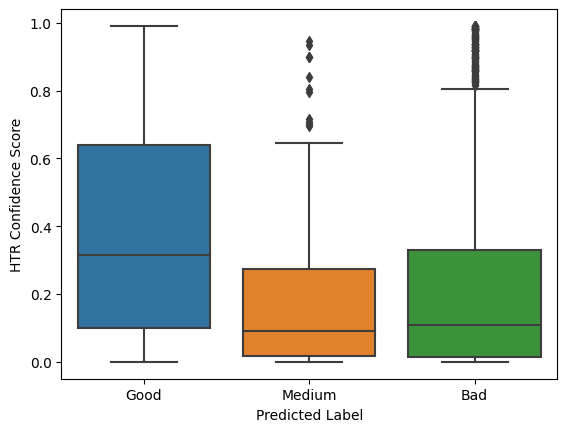

In [451]:
ax = sns.boxplot(x=results["prediction_nn"], y=results["Score"])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("HTR Confidence Score")
ax.set_xticklabels(["Good", "Medium", "Bad"])


In [452]:
mapper = {1: "Good", 2: "Medium", 3: "Bad"}
results["Predicted Quality"] = results.prediction_nn.apply(lambda x: mapper[x])
results


,index,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,prediction_nn,Predicted Quality
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.718655,steld.,[steld],0.000000,1.000000,0.000000,0.0,1,Good
1,1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.255726,"onder anderen, dat wel gem: hun Ed:s","[onder, anderen, dat, wel, gem, hun, Ed:s]",0.857143,1.000000,0.346000,0.0,1,Good
2,2,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.591369,afhandelen van eenige gewoone kom„,"[afhandelen, van, eenige, gewoone, kom]",0.551724,1.000000,0.379800,0.0,1,Good
3,3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.033434,56 „ d=o dd=o ½ lb,"[6, , d=o, dd=o, , lb]",0.100000,0.600000,0.000000,0.0,3,Bad
4,4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.924177,"aanstonds aan de munt afgegeeven, tot het","[aanstonds, aan, de, munt, afgegeeven, tot, het]",0.705882,1.000000,0.343143,0.0,1,Good
...,...,...,...,...,...,...,...,...,...,...,...
9932,9995,/data/globalise/1.04.02/2212/imagesnippets/NL-...,0.214229,waren na Poulo Chinco,"[waren, na, Poulo, Chinco]",0.388889,1.000000,0.000000,0.0,1,Good
9933,9996,/data/globalise/1.04.02/2213/imagesnippets/NL-...,0.070431,200. „ marlijn. . . . . . . . . . . .,"[00., , marlijn, , , , , , , , , , , .]",0.636364,1.000000,0.000000,0.0,1,Good
9934,9997,/data/globalise/1.04.02/2214/imagesnippets/NL-...,0.263756,was geraakt bij den interog=t,"[was, geraakt, bij, den, interog=t]",0.640000,0.640000,0.304400,0.0,1,Good
9935,9998,/data/globalise/1.04.02/2214/imagesnippets/NL-...,0.315377,"„ties tedekken, ten Eijnde van","[ties, tedekken, ten, Eijnde, van]",0.250000,0.666667,0.333600,0.0,1,Good


In [453]:
OUTPUT_FILE = DATA_DIR / "results_classification_rescale.csv"

output_columns = ["File", "Score", "text", "Predicted Quality"]

if OUTPUT_FILE.exists():
    raise FileExistsError(OUTPUT_FILE)

results[output_columns].to_csv(OUTPUT_FILE)


### Random Pages

In [454]:
OUTPUT_PAGES = 1000
TOTAL_PAGES = 4726734 - 6873

random_threshold = 1 - (OUTPUT_PAGES / TOTAL_PAGES)

random_threshold


0.9997881293538093

In [455]:
import random
import tarfile

current_page = None
select = False
lines = []

with tqdm(
    total=OUTPUT_PAGES, unit="page", desc="Selecting Pages"
) as pbar, tarfile.open(RESULTS_FILE, "r:bz2") as tar:
    for tarinfo in tqdm(tar, total=TOTAL_FILES, unit="file", desc="Reading Tar file"):
        if pbar.n >= OUTPUT_PAGES:
            break
        for line in tar.extractfile(tarinfo):
            if pbar.n >= OUTPUT_PAGES:
                break
            try:
                decoded = line.decode(ENCODING)

                path = Path(decoded.split("\t")[0])
                filename = path.parent.name

                if filename != current_page:
                    logging.debug(f"New page: '{filename}'")
                    current_page = filename
                    select = random.random() >= random_threshold
                    if select:
                        logging.info(f"Page selected: '{filename}'")
                        pbar.update()
                if select:
                    lines.append(decoded)

            except Exception as e:
                logging.error(
                    f"Failed to parse file '{tarinfo.name}', skipping: {str(e)}"
                )

len(lines)


Selecting Pages:  24%|██▍       | 240/1000 [06:07<17:23,  1.37s/page]  

In [ ]:
from io import StringIO

results_pages = pd.read_csv(
    StringIO(os.linesep.join(lines)),
    delimiter="\t",
    header=None,
    names=["File", "Score", "text"],
    dtype={"text": str},
).dropna(subset="text")
results_pages


,File,Score,text
0,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.006026,en negen ste:s zegge. - -
1,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.004957,en verder volbeslag â ƒ 50. - - ider. . . . . ...
2,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.106500,4:- „ ijzere kiatsers.
3,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.682879,.
4,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.186282,lager
...,...,...,...
37544,/data/globalise/1.04.02/9992/imagesnippets/NL-...,0.125209,M: la Masor pai tout le corps
37545,/data/globalise/1.04.02/9992/imagesnippets/NL-...,0.008971,"malleureux, Cest que lem fante"
37546,/data/globalise/1.04.02/9992/imagesnippets/NL-...,0.004715,Jl ij 1. treo long tems que je souffre
37547,/data/globalise/1.04.02/9992/imagesnippets/NL-...,0.043859,Monsiem le Gouverneur


In [ ]:
results_pages["page"] = results_pages.File.apply(lambda x: Path(x).parent.name)
results_pages


,File,Score,text,page
0,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.006026,en negen ste:s zegge. - -,NL-HaNA_1.04.02_10010_0140
1,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.004957,en verder volbeslag â ƒ 50. - - ider. . . . . ...,NL-HaNA_1.04.02_10010_0140
2,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.106500,4:- „ ijzere kiatsers.,NL-HaNA_1.04.02_10010_0140
3,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.682879,.,NL-HaNA_1.04.02_10010_0140
4,/data/globalise/1.04.02/10010/imagesnippets/NL...,0.186282,lager,NL-HaNA_1.04.02_10010_0140
...,...,...,...,...
37544,/data/globalise/1.04.02/9992/imagesnippets/NL-...,0.125209,M: la Masor pai tout le corps,NL-HaNA_1.04.02_9992_0014
37545,/data/globalise/1.04.02/9992/imagesnippets/NL-...,0.008971,"malleureux, Cest que lem fante",NL-HaNA_1.04.02_9992_0014
37546,/data/globalise/1.04.02/9992/imagesnippets/NL-...,0.004715,Jl ij 1. treo long tems que je souffre,NL-HaNA_1.04.02_9992_0014
37547,/data/globalise/1.04.02/9992/imagesnippets/NL-...,0.043859,Monsiem le Gouverneur,NL-HaNA_1.04.02_9992_0014


In [ ]:
merged_pages = (
    results_pages[["page", "text"]]
    .groupby("page")
    .agg({"text": os.linesep.join})
    .reset_index()
)
merged_pages


,page,text
0,NL-HaNA_1.04.02_10010_0140,en negen ste:s zegge. - -\nen verder volbeslag...
1,NL-HaNA_1.04.02_10014_0218,zijn van dien aard dat we bij onze daar\nCompl...
2,NL-HaNA_1.04.02_10026_0087,3\n3\n_\n15\ndd„o\nPapp9\nS:\n1._\nraesband to...
3,NL-HaNA_1.04.02_10033_0794,waarop ons instonds soo veel hangies\ndoorgans...
4,NL-HaNA_1.04.02_10038_0727,Raport in Eerbied opge„\nvolgens de g'eere ord...
...,...,...
993,NL-HaNA_1.04.02_9936_0268,"beesten, onderscheijden met n:o 2.\ntens, nomb..."
994,NL-HaNA_1.04.02_9953_0036,Die heevige klachten die uw wel Edele\nin den ...
995,NL-HaNA_1.04.02_9956_0364,1\nNij7.
996,NL-HaNA_1.04.02_9975_0224,1\n1\n9


In [ ]:
merged_pages["tokens"] = merged_pages.text.apply(get_tokens)
merged_pages


,page,text,tokens
0,NL-HaNA_1.04.02_10010_0140,en negen ste:s zegge. - -\nen verder volbeslag...,"[en, negen, ste:s, zegge, , en, verder, volbes..."
1,NL-HaNA_1.04.02_10014_0218,zijn van dien aard dat we bij onze daar\nCompl...,"[zijn, van, dien, aard, dat, we, bij, onze, da..."
2,NL-HaNA_1.04.02_10026_0087,3\n3\n_\n15\ndd„o\nPapp9\nS:\n1._\nraesband to...,"[, , , 5, dd„o, Papp, S, ._, raesband, toag, d..."
3,NL-HaNA_1.04.02_10033_0794,waarop ons instonds soo veel hangies\ndoorgans...,"[waarop, ons, instonds, soo, veel, hangies, do..."
4,NL-HaNA_1.04.02_10038_0727,Raport in Eerbied opge„\nvolgens de g'eere ord...,"[Raport, in, Eerbied, opge, volgens, de, g'eer..."
...,...,...,...
993,NL-HaNA_1.04.02_9936_0268,"beesten, onderscheijden met n:o 2.\ntens, nomb...","[beesten, onderscheijden, met, n:o, ., tens, n..."
994,NL-HaNA_1.04.02_9953_0036,Die heevige klachten die uw wel Edele\nin den ...,"[Die, heevige, klachten, die, uw, wel, Edele, ..."
995,NL-HaNA_1.04.02_9956_0364,1\nNij7.,"[, Nij7]"
996,NL-HaNA_1.04.02_9975_0224,1\n1\n9,"[, , ]"


In [ ]:
merged_pages["dict_score"] = merged_pages.tokens.apply(get_dict_score)
merged_pages.iloc[merged_pages.dict_score.sort_values().index]


,page,text,tokens,dict_score
111,NL-HaNA_1.04.02_1128_0548,1\n„\n„\n3\n_\n3\n1\n„\n6\n„\n6\n1\n6,"[, , , , , , , , , , , , ]",0.0
762,NL-HaNA_1.04.02_7547_0157,„\n1,"[, ]",0.0
861,NL-HaNA_1.04.02_8815_0412,1,[],0.0
996,NL-HaNA_1.04.02_9975_0224,1\n1\n9,"[, , ]",0.0
62,NL-HaNA_1.04.02_10620_0169,1,[],0.0
...,...,...,...,...
80,NL-HaNA_1.04.02_1084_0366,11,[1],1.0
132,NL-HaNA_1.04.02_1203_0655,85,[5],1.0
53,NL-HaNA_1.04.02_10503_0326,E\n1\nC\n1\n5\n1\n9\n9\n_\n„\n3\n9\n3\n„\n9\n_...,"[E, , C, , , , , , , , , , , , , , , , , e]",1.0
841,NL-HaNA_1.04.02_8480_0139,1\n1\n6\n1\n9\nd\n1,"[, , , , , d, ]",1.0


In [ ]:
merged_pages["dict_score_gt"] = merged_pages.tokens.apply(get_dict_score_gt)
merged_pages.iloc[merged_pages.dict_score_gt.sort_values().index]


,page,text,tokens,dict_score,dict_score_gt
46,NL-HaNA_1.04.02_10459_0422,1\n1\n1,"[, , ]",0.000000,0.0
995,NL-HaNA_1.04.02_9956_0364,1\nNij7.,"[, Nij7]",0.000000,0.0
996,NL-HaNA_1.04.02_9975_0224,1\n1\n9,"[, , ]",0.000000,0.0
62,NL-HaNA_1.04.02_10620_0169,1,[],0.000000,0.0
514,NL-HaNA_1.04.02_2713_1168,gecoll:,[gecoll],0.000000,0.0
...,...,...,...,...,...
450,NL-HaNA_1.04.02_2482_0597,1\n200\n2004\nIden,"[, 00, 004, Iden]",0.555556,1.0
920,NL-HaNA_1.04.02_9212_0124,2\n2\nA,"[, , A]",1.000000,1.0
53,NL-HaNA_1.04.02_10503_0326,E\n1\nC\n1\n5\n1\n9\n9\n_\n„\n3\n9\n3\n„\n9\n_...,"[E, , C, , , , , , , , , , , , , , , , , e]",1.000000,1.0
731,NL-HaNA_1.04.02_4253_0522,4\n2\n120\n437\n1/8,"[, , 20, 37, /8]",0.666667,1.0


In [ ]:
merged_pages["n_gram_score"] = merged_pages.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams[:MAX_N_GRAMS])
)
merged_pages.iloc[merged_pages.n_gram_score.sort_values().index]


,page,text,tokens,dict_score,dict_score_gt,n_gram_score
387,NL-HaNA_1.04.02_2217_0658,1\nG\nGe\n5: 0.,"[, G, Ge, :, .]",0.600000,1.000000,0.000000
441,NL-HaNA_1.04.02_2451_0302,1\nN„o 89\n69,"[, N„o, 9, 9]",0.400000,1.000000,0.000000
706,NL-HaNA_1.04.02_4003_1683,"tentoos Hollant, en des avonts noch aeno\ncov\...","[tentoos, Hollant, en, des, avonts, noch, aeno...",0.342857,0.533333,0.000000
730,NL-HaNA_1.04.02_4249_0166,d3\n1\n1\n1\nd..\n-\n„.\n1\n1\n1\n1\n1\n1\n1\n...,"[d, , , , d., ., , , , , , , , , , ]",0.250000,1.000000,0.000000
731,NL-HaNA_1.04.02_4253_0522,4\n2\n120\n437\n1/8,"[, , 20, 37, /8]",0.666667,1.000000,0.000000
...,...,...,...,...,...,...
494,NL-HaNA_1.04.02_2626_0592,den koning Sammorijn sijn beklag ge„\nmitteerd...,"[den, koning, Sammorijn, sijn, beklag, ge, mit...",0.497727,0.812500,0.208506
44,NL-HaNA_1.04.02_10407_0087,rccommandeert voortaan bij het op=\ntendiende ...,"[rccommandeert, voortaan, bij, het, optendiend...",0.631105,0.826478,0.209425
454,NL-HaNA_1.04.02_2487_0467,16.\nden zesden gev: vervalt.\n3\ndes tijds ve...,"[6., den, zesden, gev, vervalt, , des, tijds, ...",0.568056,0.863889,0.216915
386,NL-HaNA_1.04.02_2208_0082,queste alsoo het eerstgem: als\n„nus versluijs...,"[queste, alsoo, het, eerstgem, als, nus, versl...",0.565814,0.867459,0.220537


In [ ]:
merged_pages["garbage_score"] = merged_pages.tokens.apply(get_garbage_score)
merged_pages.iloc[merged_pages.garbage_score.sort_values().index]


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score
997,NL-HaNA_1.04.02_9992_0014,=die par quel quan raisonnable: la der=\ngens ...,"[die, par, quel, quan, raisonnable, la, dergen...",0.322394,0.397683,0.030349,0.000000
595,NL-HaNA_1.04.02_3335_0055,om met 30 p„s Thotassen groffe geriefd te word...,"[om, met, 0, p„s, Thotassen, groffe, geriefd, ...",0.495825,0.856994,0.165572,0.000000
596,NL-HaNA_1.04.02_3340_0363,de ordre.\nwerd betaald en dewijl zulx nog al ...,"[de, ordre, werd, betaald, en, dewijl, zulx, n...",0.522222,0.726984,0.095633,0.000000
239,NL-HaNA_1.04.02_1541_1089,schooten vande Vijanden die van tfort\ndaar va...,"[schooten, vande, Vijanden, die, van, tfort, d...",0.548193,0.802065,0.159616,0.000000
597,NL-HaNA_1.04.02_3340_0496,„heid in agt genoomen soude werden om\nWij heb...,"[heid, in, agt, genoomen, soude, werden, om, W...",0.532731,0.966140,0.119159,0.000000
...,...,...,...,...,...,...,...
531,NL-HaNA_1.04.02_2793_0231,fo 17 50„\n7\nRendement\nN 1: N 3.1.\nR\nTimor...,"[fo, 7, 0„, , Rendement, N, :, N, .1., R, Timo...",0.562500,0.656250,0.000000,0.153846
792,NL-HaNA_1.04.02_7943_0486,. . . . „ 12000: _ -„ 746: 4:-„ 1175: 16:-„ 57...,"[, , , , , 2000:, , „, 46:, :-„, 175:, 6:-„, 7...",0.170226,0.785845,0.004940,0.175192
731,NL-HaNA_1.04.02_4253_0522,4\n2\n120\n437\n1/8,"[, , 20, 37, /8]",0.666667,1.000000,0.000000,0.200000
379,NL-HaNA_1.04.02_2172_0685,Zeeland\nRRotterdam\nFlora.\nEnkhuijsen\nberke...,"[Zeeland, RRotterdam, Flora, Enkhuijsen, berke...",0.243567,0.828247,0.021778,0.384501


In [ ]:
from sklearn import preprocessing

merged_pages_scaled = scaler.transform(merged_pages[x_fields].to_numpy())

merged_pages_scaled


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[-0.46737087, -0.84907946, -1.07241331,  0.4767274 ],
       [ 1.15949215,  0.50573698,  1.12236575, -0.69433921],
       [-0.15011393, -1.3608838 , -0.83480125,  0.25378549],
       ...,
       [-3.91614355, -7.13604649, -2.2031105 , -0.69433921],
       [-3.91614355, -7.13604649, -2.2031105 , -0.69433921],
       [-1.36408215, -3.62203526, -1.54262732, -0.69433921]])

In [ ]:
pipeline.predict(merged_pages_scaled)


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


array([3, 1, 3, 1, 1, 3, 3, 3, 2, 1, 2, 1, 3, 3, 2, 1, 2, 3, 1, 2, 3, 1,
       1, 1, 3, 3, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       2, 3, 3, 2, 3, 2, 3, 3, 3, 2, 1, 3, 1, 3, 3, 2, 3, 2, 3, 1, 2, 3,
       1, 1, 1, 1, 1, 3, 2, 1, 1, 2, 1, 3, 1, 3, 2, 1, 1, 3, 3, 2, 1, 1,
       1, 2, 2, 2, 1, 3, 1, 3, 1, 1, 1, 2, 2, 2, 3, 1, 3, 2, 1, 1, 1, 3,
       1, 3, 3, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1,
       2, 3, 1, 3, 3, 1, 1, 2, 2, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 2, 1, 3,
       1, 1, 3, 2, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3,
       1, 3, 2, 1, 3, 1, 2, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 2,
       3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 2, 1, 1,
       1, 3, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3,
       1, 1, 3, 1, 1, 1, 3, 1, 2, 3, 3, 3, 1, 3, 2, 1, 1, 3, 1, 3, 1, 1,
       3, 2, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3,
       3, 1, 2, 3, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1,

In [ ]:
_features = merged_pages.iloc[0][x_fields].to_dict()
pipeline.predict([list(_features.values())])


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


array([3])

In [ ]:
merged_pages["prediction_nn"] = classifier.predict(merged_pages_scaled)
merged_pages


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,prediction_nn
0,NL-HaNA_1.04.02_10010_0140,en negen ste:s zegge. - -\nen verder volbeslag...,"[en, negen, ste:s, zegge, , en, verder, volbes...",0.435673,0.711501,0.051955,0.031469,3
1,NL-HaNA_1.04.02_10014_0218,zijn van dien aard dat we bij onze daar\nCompl...,"[zijn, van, dien, aard, dat, we, bij, onze, da...",0.641189,0.864827,0.152803,0.000000,1
2,NL-HaNA_1.04.02_10026_0087,3\n3\n_\n15\ndd„o\nPapp9\nS:\n1._\nraesband to...,"[, , , 5, dd„o, Papp, S, ._, raesband, toag, d...",0.475751,0.653580,0.062873,0.025478,3
3,NL-HaNA_1.04.02_10033_0794,waarop ons instonds soo veel hangies\ndoorgans...,"[waarop, ons, instonds, soo, veel, hangies, do...",0.507463,0.750746,0.092953,0.000000,1
4,NL-HaNA_1.04.02_10038_0727,Raport in Eerbied opge„\nvolgens de g'eere ord...,"[Raport, in, Eerbied, opge, volgens, de, g'eer...",0.505952,0.767857,0.110447,0.009709,1
...,...,...,...,...,...,...,...,...
993,NL-HaNA_1.04.02_9936_0268,"beesten, onderscheijden met n:o 2.\ntens, nomb...","[beesten, onderscheijden, met, n:o, ., tens, n...",0.519940,0.835967,0.105090,0.025271,1
994,NL-HaNA_1.04.02_9953_0036,Die heevige klachten die uw wel Edele\nin den ...,"[Die, heevige, klachten, die, uw, wel, Edele, ...",0.570016,0.769357,0.153336,0.012146,1
995,NL-HaNA_1.04.02_9956_0364,1\nNij7.,"[, Nij7]",0.000000,0.000000,0.000000,0.000000,3
996,NL-HaNA_1.04.02_9975_0224,1\n1\n9,"[, , ]",0.000000,0.000000,0.000000,0.000000,3


In [ ]:
probs = classifier.predict_proba(merged_pages_scaled)

merged_pages["prediction_nn_prob"] = np.take_along_axis(
    probs, merged_pages.prediction_nn.subtract(1)[:, None], axis=1
)
merged_pages


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_26382/1392524174.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  probs, merged_pages.prediction_nn.subtract(1)[:, None], axis=1


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,prediction_nn,prediction_nn_prob
0,NL-HaNA_1.04.02_10010_0140,en negen ste:s zegge. - -\nen verder volbeslag...,"[en, negen, ste:s, zegge, , en, verder, volbes...",0.435673,0.711501,0.051955,0.031469,3,0.735786
1,NL-HaNA_1.04.02_10014_0218,zijn van dien aard dat we bij onze daar\nCompl...,"[zijn, van, dien, aard, dat, we, bij, onze, da...",0.641189,0.864827,0.152803,0.000000,1,0.833582
2,NL-HaNA_1.04.02_10026_0087,3\n3\n_\n15\ndd„o\nPapp9\nS:\n1._\nraesband to...,"[, , , 5, dd„o, Papp, S, ._, raesband, toag, d...",0.475751,0.653580,0.062873,0.025478,3,0.573578
3,NL-HaNA_1.04.02_10033_0794,waarop ons instonds soo veel hangies\ndoorgans...,"[waarop, ons, instonds, soo, veel, hangies, do...",0.507463,0.750746,0.092953,0.000000,1,0.793032
4,NL-HaNA_1.04.02_10038_0727,Raport in Eerbied opge„\nvolgens de g'eere ord...,"[Raport, in, Eerbied, opge, volgens, de, g'eer...",0.505952,0.767857,0.110447,0.009709,1,0.715540
...,...,...,...,...,...,...,...,...,...
993,NL-HaNA_1.04.02_9936_0268,"beesten, onderscheijden met n:o 2.\ntens, nomb...","[beesten, onderscheijden, met, n:o, ., tens, n...",0.519940,0.835967,0.105090,0.025271,1,0.622142
994,NL-HaNA_1.04.02_9953_0036,Die heevige klachten die uw wel Edele\nin den ...,"[Die, heevige, klachten, die, uw, wel, Edele, ...",0.570016,0.769357,0.153336,0.012146,1,0.593610
995,NL-HaNA_1.04.02_9956_0364,1\nNij7.,"[, Nij7]",0.000000,0.000000,0.000000,0.000000,3,0.997926
996,NL-HaNA_1.04.02_9975_0224,1\n1\n9,"[, , ]",0.000000,0.000000,0.000000,0.000000,3,0.997926


In [ ]:
mapper = {1: "Good", 2: "Medium", 3: "Bad"}
merged_pages["Predicted Quality"] = merged_pages.prediction_nn.apply(
    lambda x: mapper[x]
)
merged_pages


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,prediction_nn,prediction_nn_prob,Predicted Quality
0,NL-HaNA_1.04.02_10010_0140,en negen ste:s zegge. - -\nen verder volbeslag...,"[en, negen, ste:s, zegge, , en, verder, volbes...",0.435673,0.711501,0.051955,0.031469,3,0.735786,Bad
1,NL-HaNA_1.04.02_10014_0218,zijn van dien aard dat we bij onze daar\nCompl...,"[zijn, van, dien, aard, dat, we, bij, onze, da...",0.641189,0.864827,0.152803,0.000000,1,0.833582,Good
2,NL-HaNA_1.04.02_10026_0087,3\n3\n_\n15\ndd„o\nPapp9\nS:\n1._\nraesband to...,"[, , , 5, dd„o, Papp, S, ._, raesband, toag, d...",0.475751,0.653580,0.062873,0.025478,3,0.573578,Bad
3,NL-HaNA_1.04.02_10033_0794,waarop ons instonds soo veel hangies\ndoorgans...,"[waarop, ons, instonds, soo, veel, hangies, do...",0.507463,0.750746,0.092953,0.000000,1,0.793032,Good
4,NL-HaNA_1.04.02_10038_0727,Raport in Eerbied opge„\nvolgens de g'eere ord...,"[Raport, in, Eerbied, opge, volgens, de, g'eer...",0.505952,0.767857,0.110447,0.009709,1,0.715540,Good
...,...,...,...,...,...,...,...,...,...,...
993,NL-HaNA_1.04.02_9936_0268,"beesten, onderscheijden met n:o 2.\ntens, nomb...","[beesten, onderscheijden, met, n:o, ., tens, n...",0.519940,0.835967,0.105090,0.025271,1,0.622142,Good
994,NL-HaNA_1.04.02_9953_0036,Die heevige klachten die uw wel Edele\nin den ...,"[Die, heevige, klachten, die, uw, wel, Edele, ...",0.570016,0.769357,0.153336,0.012146,1,0.593610,Good
995,NL-HaNA_1.04.02_9956_0364,1\nNij7.,"[, Nij7]",0.000000,0.000000,0.000000,0.000000,3,0.997926,Bad
996,NL-HaNA_1.04.02_9975_0224,1\n1\n9,"[, , ]",0.000000,0.000000,0.000000,0.000000,3,0.997926,Bad


<Axes: >

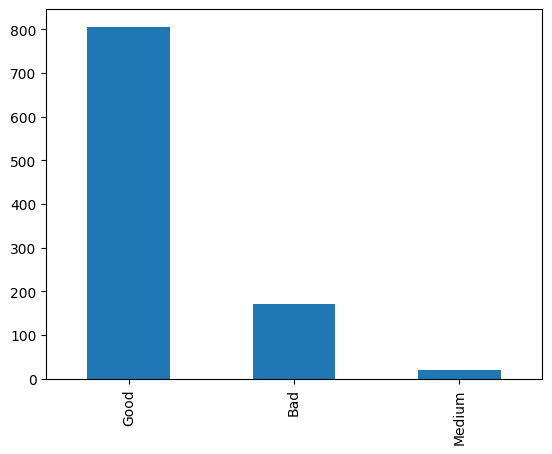

In [ ]:
merged_pages["Predicted Quality"].value_counts().plot(kind="bar")


Text(0, 0.5, 'Predicted Quality Confidence')

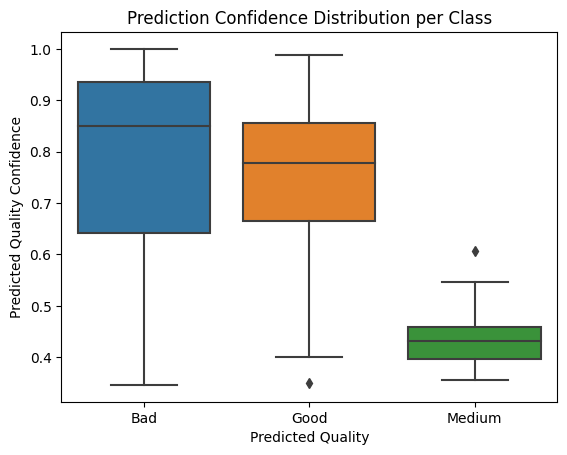

In [ ]:
ax = sns.boxplot(x=merged_pages["Predicted Quality"], y=merged_pages.prediction_nn_prob)
ax.set_title("Prediction Confidence Distribution per Class")
ax.set_ylabel("Predicted Quality Confidence")


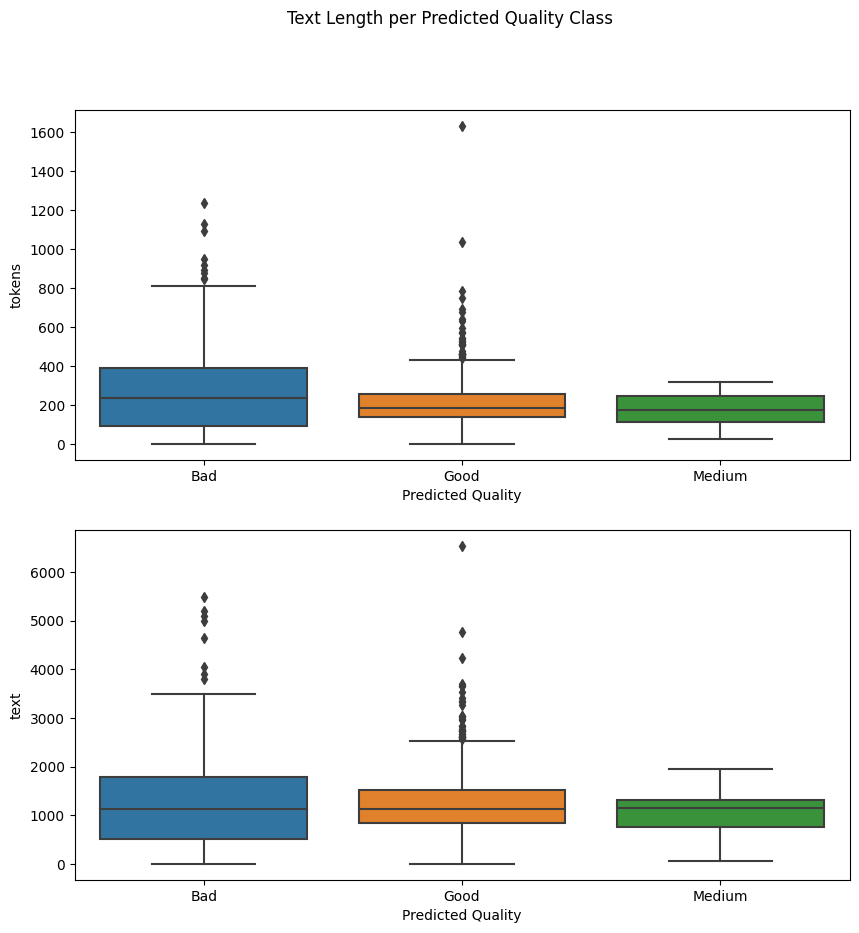

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 10), sharex=False, sharey=False)

fig.suptitle("Text Length per Predicted Quality Class")

for ax, field in zip(axs, ("tokens", "text")):
    sns.boxplot(
        x=merged_pages["Predicted Quality"], y=merged_pages[field].str.len(), ax=ax
    )
    ax.set_ylabel(field)


In [ ]:
import logging

OUTPUT_FILE = DATA_DIR / "results_pages_classification_rescaled.csv"

output_columns = ["page", "text", "Predicted Quality"]

if OUTPUT_FILE.exists():
    logging.error(f"Output file already exists: '{OUTPUT_FILE.absolute()}'")
    # raise FileExistsError(OUTPUT_FILE)
else:
    merged_pages[output_columns].to_csv(OUTPUT_FILE)


ERROR:root:Output file already exists: '/Users/carstenschnober/LAHTeR/workspace/nautilusocr/data/results_pages_classification_rescaled.csv'
